# Experiment Run

Information Geometry Soft Clustering for Sport Analytics

Joaquin Garay

In [1]:
%load_ext autoreload
%autoreload 2

import os
from time import time
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import vis
import softclustering as sc
import socceraction.spadl as spadl

### Load data

In [2]:
datafolder = "data"
fifa2018h5 = os.path.join(datafolder, "spadl-fifa2018.h5")
games = pd.read_hdf(fifa2018h5, key="games")
with pd.HDFStore(fifa2018h5) as store:
    actions = []  #list of DataFrames
    for game in tqdm(games.itertuples()):
        game_action = store[f"actions/game_{game.game_id}"]
        game_action = spadl.play_left_to_right(game_action, game.home_team_id)
        game_action["is_home"] = game_action["team_id"] == game.home_team_id
        actions.append(game_action)
    actions = pd.concat(actions)
    actions.drop("original_event_id", axis=1, inplace=True)
    actions = pd.merge(actions, spadl.config.actiontypes_df(), how="left")
    actions = sc.consolidate(actions)
    actions = sc.add_noise(actions)
    actions = sc.remove_outliers(actions, True)
    actions["angle"] = np.arctan2(actions.end_y - actions.start_y, actions.end_x - actions.start_x)
    actions["cos_angle"] = np.cos(actions["angle"])
    actions["sin_angle"] = np.sin(actions["angle"])



64it [00:00, 174.67it/s]


Remove 551 out of 128484 datapoints.


## Experiment

There are 10 action types that are to be clustered using Gaussian mixture distribution. Some of the actions have not and end location, thus are not relevant for this research because we cannot compute their direction. Also the action "shot_penalty" always has the same start location, so no need to cluster them.

In [3]:
# select actions type to run location soft clustering
# shot penalty has always the same starting point
no_dir_action_types = set(actions[actions["angle"] == 0.0]["type_name"])
action_types = set(actions["type_name"]) - no_dir_action_types - {"shot_penalty"}
action_types

{'clearance',
 'corner',
 'cross',
 'dribble',
 'freekick',
 'goalkick',
 'keeper_action',
 'pass',
 'shot',
 'throw_in'}

### Location mixture: Number of clusters calibration

We look for the optimal number of location clusters for each action type based on a modified Calinski–Harabasz index for soft clustering.
$$CH = \frac{BC/(K-1)}{WC/(N-K)},$$
where between-cluster distance ($BC$) and within-cluster distance ($WC$) are defined as:
$$BC = \min_{\bar{\eta}}\sum_{j=1}^K \pi_j D_{\phi}[\eta_j : \bar{\eta}], \quad WC = -\sum_{i=1}^N\sum_{j=1}^K \ln (f(x_i|\theta_j)\cdot \pi_j) \, P(C_j|x_i).$$

In [4]:
rows = []
for action_type in action_types:
    print(f"\nProcessing {action_type}:")
    mask = (actions["type_name"] == action_type)  #& (actions["team_id"] == 771)
    loc_data = actions[mask][["start_x", "start_y"]]

    for model in ["classic"]:
        print(f" {model}", end="")
        for init_method in ["k-means"]:
            for K in range(2, 6):
                print(f" {K} clus.,", end="")
                gauss_clusters = [sc.MultivariateGaussian() for _ in range(K)]

                start = time()
                loc_model = sc.MixtureModel(gauss_clusters,
                                            init=init_method)
                loc_model.fit(loc_data, verbose=False, case=model)
                end = time() - start

                rows.append({
                    "action_type": action_type,
                    "model" : model,
                    "initialization":init_method,
                    "cluster_nbr": K,
                    "ch_score": round(loc_model.kl_ch_score(loc_data), 5),
                    "bic_score": round(loc_model.bic_score(loc_data), 0),
                    "aic_score": round(loc_model.aic_score(loc_data), 0),
                    "running_time": round(end,3)
                })

loc_scores = pd.DataFrame(rows)


Processing throw_in:
 classic 2 clus., 3 clus., 4 clus., 5 clus.,
Processing keeper_action:
 classic 2 clus., 3 clus., 4 clus., 5 clus.,
Processing freekick:
 classic 2 clus., 3 clus., 4 clus., 5 clus.,
Processing cross:
 classic 2 clus., 3 clus., 4 clus., 5 clus.,
Processing pass:
 classic 2 clus., 3 clus., 4 clus., 5 clus.,
Processing goalkick:
 classic 2 clus., 3 clus., 4 clus., 5 clus.,
Processing shot:
 classic 2 clus., 3 clus., 4 clus., 5 clus.,
Processing dribble:
 classic 2 clus., 3 clus., 4 clus., 5 clus.,
Processing clearance:
 classic 2 clus., 3 clus., 4 clus., 5 clus.,
Processing corner:
 classic 2 clus., 3 clus., 4 clus., 5 clus.,

In [5]:
df = loc_scores.sort_values(by=["action_type","ch_score"], ascending=[True,False])
df

action_type    model initialization  cluster_nbr      ch_score  \
32      clearance  classic        k-means            2  2.501200e-01   
33      clearance  classic        k-means            3  1.560800e-01   
34      clearance  classic        k-means            4  1.539500e-01   
35      clearance  classic        k-means            5  1.506800e-01   
36         corner  classic        k-means            2  1.188771e+03   
38         corner  classic        k-means            4 -2.577070e+06   
37         corner  classic        k-means            3 -1.490143e+07   
39         corner  classic        k-means            5 -4.279363e+08   
12          cross  classic        k-means            2  1.857580e+00   
15          cross  classic        k-means            5  1.317520e+00   
13          cross  classic        k-means            3  1.205900e+00   
14          cross  classic        k-means            4  8.902300e-01   
29        dribble  classic        k-means            3  7.182600e-01   
31        dribble  classic        k-means            5  6.485400e-01   
30        dribble  classic        k-means            4  4.850600e-01   
28        dribble  classic        k-means            2  2.790900e-01   
11       freekick  classic        k-means            5  5.014300e-01   
8        freekick  classic        k-means            2  2.959200e-01   
9        freekick  classic        k-means            3  2.606400e-01   
10       freekick  classic        k-means            4  2.150100e-01   
23       goalkick  classic        k-means            5  4.539500e-01   
22       goalkick  classic        k-means            4  2.782200e-01   
21       goalkick  classic        k-means            3  1.882900e-01   
20       goalkick  classic        k-means            2  7.219000e-02   
7   keeper_action  classic        k-means            5  5.997639e+05   
4   keeper_action  classic        k-means            2  6.449700e-01   
5   keeper_action  classic        k-means            3  5.160700e-01   
6   keeper_action  classic        k-means            4  3.726700e-01   
18           pass  classic        k-means            4  6.178700e-01   
17           pass  classic        k-means            3  5.481600e-01   
19           pass  classic        k-means            5  5.356400e-01   
16           pass  classic        k-means            2  2.607500e-01   
24           shot  classic        k-means            2  2.979500e-01   
25           shot  classic        k-means            3  2.321900e-01   
26           shot  classic        k-means            4  2.081000e-01   
27           shot  classic        k-means            5  1.477700e-01   
3        throw_in  classic        k-means            5  2.701167e+10   
2        throw_in  classic        k-means            4  1.342317e+10   
0        throw_in  classic        k-means            2  5.423740e+02   
1        throw_in  classic        k-means            3  2.691785e+02   

    bic_score  aic_score  running_time  
32    27361.0    27288.0         0.148  
33    27337.0    27225.0         0.307  
34    27273.0    27122.0         0.742  
35    27297.0    27106.0         1.627  
36     2275.0     2219.0         0.004  
38    -2355.0    -2470.0         0.020  
37     -235.0     -320.0         0.029  
39    -2563.0    -2708.0         0.010  
12    18647.0    18580.0         0.013  
15    18413.0    18237.0         0.433  
13    18550.0    18447.0         0.302  
14    18436.0    18297.0         0.415  
29   924826.0   924648.0         7.746  
31   918201.0   917900.0        27.108  
30   924108.0   923868.0        23.516  
28   931353.0   931238.0         3.789  
11    22349.0    22175.0         0.312  
8     22595.0    22529.0         0.081  
9     22477.0    22374.0         0.341  
10    22459.0    22320.0         0.134  
23     5379.0     5225.0         1.048  
22     5346.0     5224.0         0.867  
21     5316.0     5226.0         0.295  
20     5308.0     5249.0         0.096  
7      5527.0     5378.0    

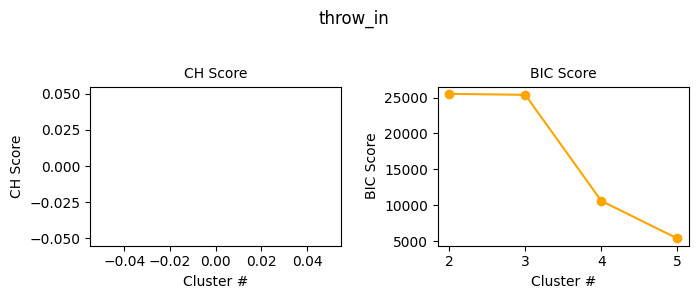

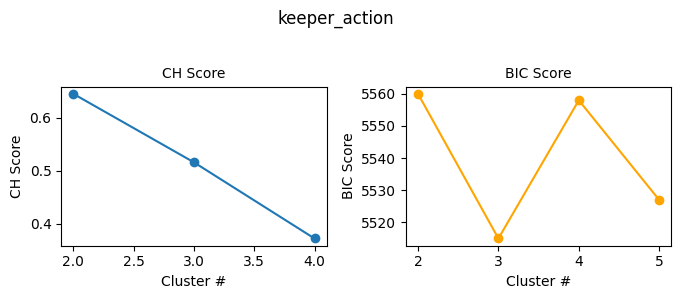

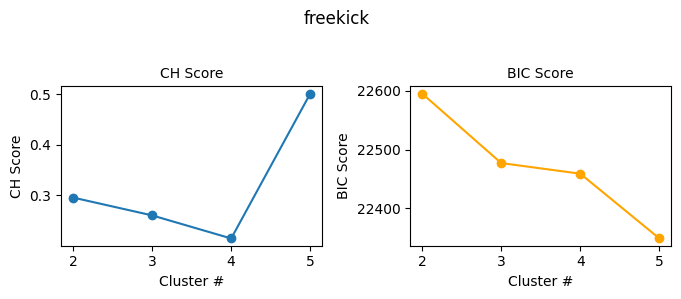

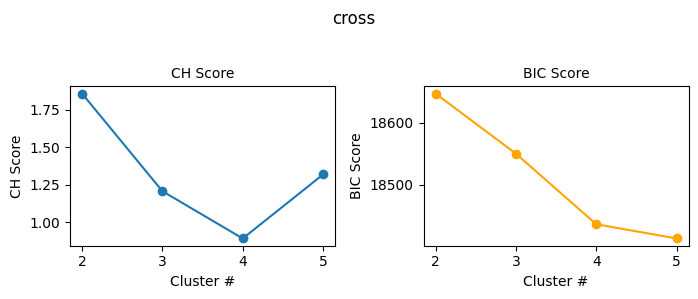

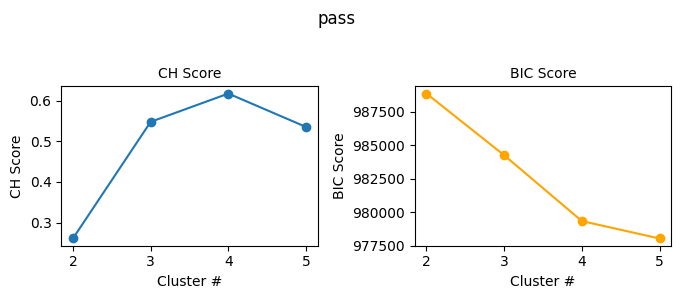

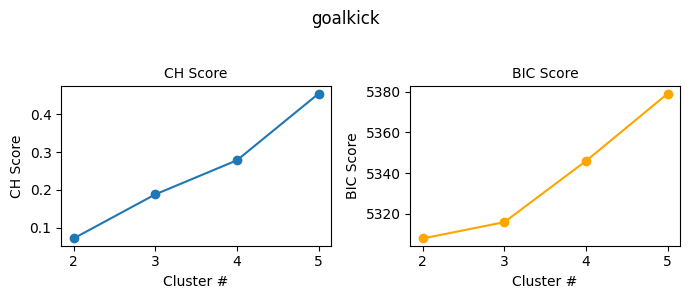

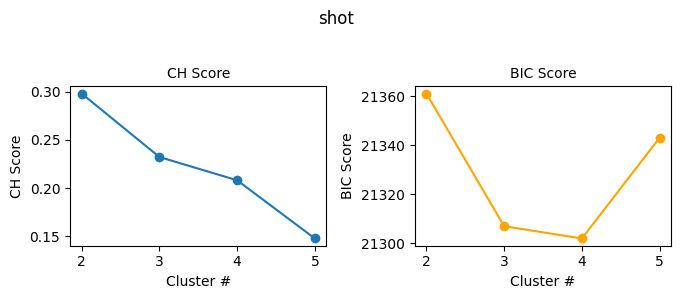

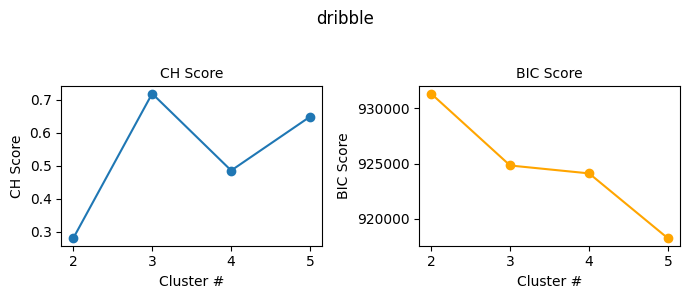

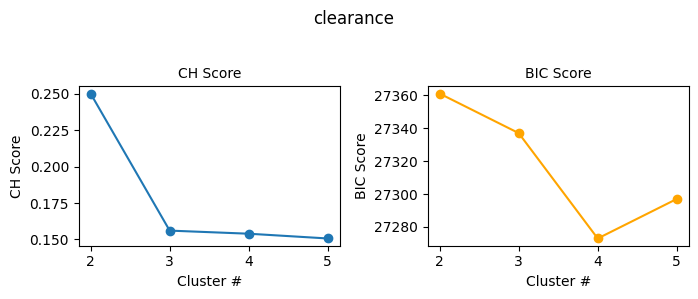

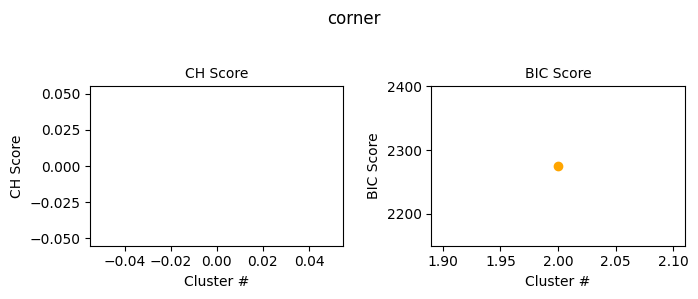

In [6]:
# Filter CH scores
loc_scores_filtered = loc_scores[(loc_scores["ch_score"] <= 2) &
                                 (loc_scores["ch_score"] > 0) &
                                 (loc_scores["model"]=="classic") &
                                 (loc_scores["initialization"]=="k-means") ]

# Loop through each action_type and make a (1,2) plot per type
for action_type in action_types:
    fig, axes = plt.subplots(1, 2, figsize=(7, 3))
    fig.suptitle(f"{action_type}", fontsize=12)

    # CH Score subplot
    ch_data = loc_scores_filtered[loc_scores_filtered["action_type"] == action_type]
    axes[0].plot(ch_data["cluster_nbr"], ch_data["ch_score"], marker="o")
    axes[0].set_title("CH Score", fontsize=10)
    axes[0].set_xlabel("Cluster #")
    axes[0].set_ylabel("CH Score")

    # BIC Score subplot
    bic_data = loc_scores[(loc_scores["action_type"] == action_type) & (loc_scores["bic_score"] > 0)]
    axes[1].plot(bic_data["cluster_nbr"], bic_data["bic_score"], marker="o", color="orange")
    axes[1].set_title("BIC Score", fontsize=10)
    axes[1].set_xlabel("Cluster #")
    axes[1].set_ylabel("BIC Score")

    plt.tight_layout(rect=(0.0, 0.0, 1.0, 0.95))
    plt.show()

In [7]:
optimal_loc_K = {
    f"{action_type}": group.loc[group["ch_score"].idxmax(), "cluster_nbr"]
    for action_type, group in loc_scores_filtered.groupby("action_type")
}
optimal_loc_K

{'clearance': 2,
 'cross': 2,
 'dribble': 3,
 'freekick': 5,
 'goalkick': 5,
 'keeper_action': 2,
 'pass': 4,
 'shot': 2}

In [8]:
optimal_loc_K = {
    'clearance': 2, # check
    'cross': 4, # manually added
    'dribble': 4, # check
    'freekick': 3, # check
    'goalkick': 3, # manually added
    'keeper_action': 3, # manually added
    'pass': 5, # manually added
    'shot': 2, # check
    'throw_in': 2,  # manually added
    'corner': 2  # manually added
}

In [9]:
loc_models = {}
for action_type in action_types:
    print(f"Processing {action_type}...")
    mask = (actions["type_name"] == action_type)
    loc_data = actions[mask][["start_x", "start_y"]]
    loc_K = optimal_loc_K[action_type]
    gauss_clusters = [sc.MultivariateGaussian() for _ in range(loc_K)]
    loc_model = sc.MixtureModel(gauss_clusters,
                                init='k-means')
    _ = loc_model.fit(loc_data, case="bregman")
    loc_models[action_type] = loc_model

Processing throw_in...
Processing keeper_action...
Processing freekick...
Processing cross...
Processing pass...
Processing goalkick...
Processing shot...
Processing dribble...
Processing clearance...
Processing corner...


In [10]:
print(loc_models["pass"])

MixtureModel(n_components=5)
  ├─ (0) w=0.075  MultivariateGaussian(d=2, mean=[56.347 64.878], cov=[[430.077  -0.21 ], [-0.21   1.937]])
  ├─ (1) w=0.075  MultivariateGaussian(d=2, mean=[57.676  2.999], cov=[[418.491  -0.559], [-0.559  1.875]])
  ├─ (2) w=0.339  MultivariateGaussian(d=2, mean=[51.951 51.029], cov=[[474.718  20.585], [20.585 54.513]])
  ├─ (3) w=0.143  MultivariateGaussian(d=2, mean=[55.788 11.66 ], cov=[[498.914   1.768], [ 1.768 24.32 ]])
  └─ (4) w=0.369  MultivariateGaussian(d=2, mean=[46.035 27.457], cov=[[436.476 -20.752], [-20.752  90.06 ]])


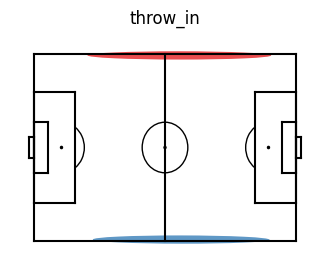

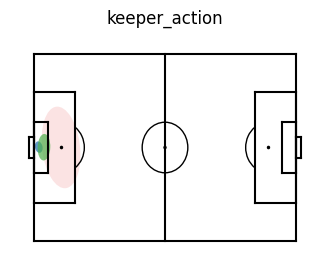

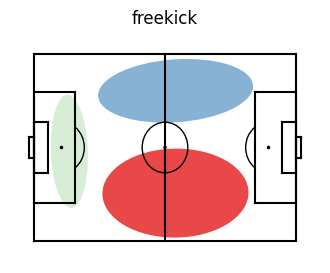

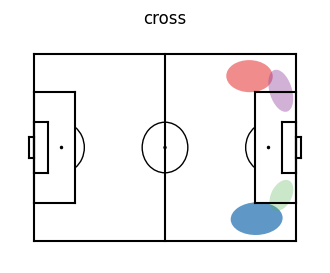

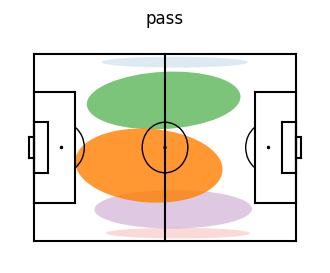

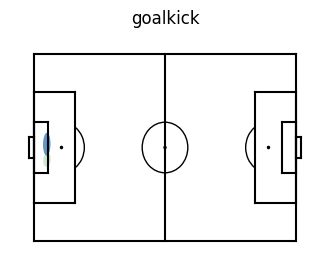

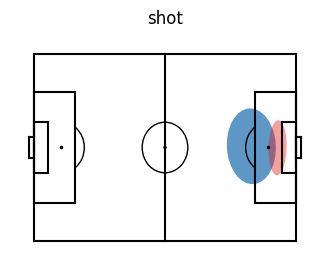

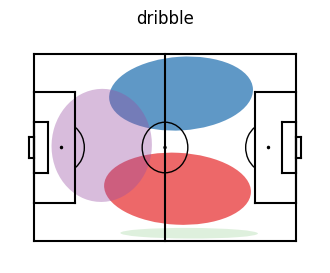

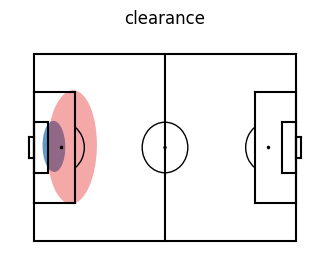

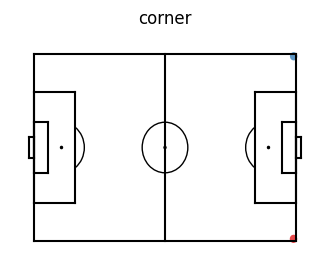

In [11]:
for action_type in action_types:
    vis.show_location_model(loc_models[action_type], figsize=4, title=action_type)

### Direction mixture: Number of cluster calibration

Similarly, we continue searching for the optimal number of cluster for the direction mixture mddel. In this case, we model a von Mises mixture distribution for each location cluster for each action type. The direction data is the full dataset as before, but weighted by the location posteriors probabilities of each cluster.

In [12]:
# takes around 22 minutes. Results are saved in data/dir_optimal_clusters.csv
rows = []
for action_type in action_types:
    print(f"\nProcessing {action_type}:")
    mask = (actions["type_name"] == action_type)
    loc_data = actions[mask][["start_x", "start_y"]]
    dir_data = actions[mask][["cos_angle", "sin_angle"]]
    N = loc_data.shape[0]
    loc_model = loc_models[action_type]
    K_loc = loc_model.n_components
    # first layer posterior is fixed
    loc_posteriors = loc_model.get_posteriors(loc_data)
    for case in ["bregman", "classic", "approximation"]:
        print(f"   Approach: {case}")
        for loc_cluster in range(K_loc):
            print(f"      Location cluster: {loc_cluster}\n         ", end="")
            for K_dir in range(2, 6):
                print(f"K={K_dir}, ", end="")
                start = time()
                dir_mixture = sc.MixtureModel([sc.VonMises() for _ in range(K_dir)],
                                              weights=None,
                                              init="k-means")
                _ = dir_mixture.fit(dir_data,
                                    sample_weight=loc_posteriors[:, loc_cluster],
                                    case=case)
                end = time() - start

                rows.append({
                    "action_type": action_type,
                    "loc_cluster": loc_cluster,
                    "cluster_nbr": K_dir,
                    "model": case,
                    "ch_score": round(dir_mixture.kl_ch_score(dir_data), 5),
                    "bic_score": round(dir_mixture.bic_score(dir_data), 0),
                    "aic_score": round(dir_mixture.aic_score(dir_data), 0),
                    "running_time": round(end, 3)
                })
            print("")

dir_scores = pd.DataFrame(rows)



Processing throw_in:
   Approach: bregman
      Location cluster: 0
         K=2, K=3, K=4, K=5, 
      Location cluster: 1
         K=2, K=3, K=4, K=5, 
   Approach: classic
      Location cluster: 0
         K=2, K=3, K=4, K=5, 
      Location cluster: 1
         K=2, K=3, K=4, K=5, 
   Approach: approximation
      Location cluster: 0
         K=2, K=3, K=4, K=5, 
      Location cluster: 1
         K=2, K=3, K=4, K=5, 

Processing keeper_action:
   Approach: bregman
      Location cluster: 0
         K=2, K=3, K=4, K=5, 
      Location cluster: 1
         K=2, K=3, K=4, K=5, 
      Location cluster: 2
         K=2, K=3, K=4, K=5, 
   Approach: classic
      Location cluster: 0
         K=2, K=3, K=4, K=5, 
      Location cluster: 1
         K=2, K=3, K=4, K=5, 
      Location cluster: 2
         K=2, K=3, K=4, K=5, 
   Approach: approximation
      Location cluster: 0
         K=2, K=3, K=4, K=5, 
      Location cluster: 1
         K=2, K=3, K=4, K=5, 
      Location cluster: 2
   

In [13]:
dir_scores

action_type  loc_cluster  cluster_nbr          model  ch_score  bic_score  \
0      throw_in            0            2        bregman   0.27259    11687.0   
1      throw_in            0            3        bregman   0.16524    14541.0   
2      throw_in            0            4        bregman   0.10860    17193.0   
3      throw_in            0            5        bregman   0.05971    28700.0   
4      throw_in            1            2        bregman   0.27376    10933.0   
..          ...          ...          ...            ...       ...        ...   
355      corner            0            5  approximation   0.01219    20791.0   
356      corner            1            2  approximation   0.08441    11218.0   
357      corner            1            3  approximation   0.04131    11225.0   
358      corner            1            4  approximation   0.01381    23740.0   
359      corner            1            5  approximation   0.01028    23746.0   

     aic_score  running_time  
0      11670.0         0.039  
1      14518.0         0.083  
2      17165.0         0.119  
3      28666.0         0.576  
4      10916.0         0.033  
..         ...           ...  
355    20766.0         0.026  
356    11206.0         0.005  
357    11208.0         0.007  
358    23718.0         0.017  
359    23720.0         0.018  

[360 rows x 8 columns]

In [14]:
best_scores = dir_scores.loc[
    dir_scores.groupby(["action_type", "loc_cluster", "model"])["ch_score"].idxmax()
]
optimal_dir_K = best_scores[["action_type", "loc_cluster", "model", "cluster_nbr"]]
optimal_dir_K.reset_index(drop=True, inplace=True)
best_scores.sort_values(by=["action_type", "loc_cluster", "ch_score"], ascending=[True, True, False], inplace=True)
best_scores

action_type  loc_cluster  cluster_nbr          model  ch_score  bic_score  \
328   clearance            0            2  approximation   0.22048     6145.0   
320   clearance            0            2        classic   0.21909     6142.0   
312   clearance            0            2        bregman   0.21668     6141.0   
325   clearance            1            3        classic   0.14964     6138.0   
317   clearance            1            3        bregman   0.13894     6139.0   
..          ...          ...          ...            ...       ...        ...   
8      throw_in            0            2        classic   0.27279    11718.0   
0      throw_in            0            2        bregman   0.27259    11687.0   
12     throw_in            1            2        classic   0.27382    10956.0   
4      throw_in            1            2        bregman   0.27376    10933.0   
20     throw_in            1            2  approximation   0.27372    11090.0   

     aic_score  running_time  
328     6128.0         0.111  
320     6125.0         0.679  
312     6124.0         0.192  
325     6116.0         1.382  
317     6116.0         0.398  
..         ...           ...  
8      11701.0         0.704  
0      11670.0         0.039  
12     10939.0         0.158  
4      10916.0         0.033  
20     11073.0         0.032  

[90 rows x 8 columns]

In [15]:
optimal_dir_K.to_csv("data/dir_optimal_clusters.csv", index=False)

In [16]:
optimal_dir_K = pd.read_csv("data/dir_optimal_clusters.csv")

In [17]:
optimal_dir_K

action_type  loc_cluster          model  cluster_nbr
0    clearance            0  approximation            2
1    clearance            0        bregman            2
2    clearance            0        classic            2
3    clearance            1  approximation            5
4    clearance            1        bregman            3
..         ...          ...            ...          ...
85    throw_in            0        bregman            2
86    throw_in            0        classic            2
87    throw_in            1  approximation            2
88    throw_in            1        bregman            2
89    throw_in            1        classic            2

[90 rows x 4 columns]

In [18]:
 # Run using optimal number of clusters. Takes around 15 minutes.
experiment = {}
rows = []
for method in ["bregman", "approximation", "classic"]:
    for init in ["k-means++", "k-means", "random", "random_from_data"]:
        dir_models = {}
        for action_type in action_types:
            mask = (actions["type_name"] == action_type)
            loc_data = actions[mask][["start_x", "start_y"]]
            dir_data = actions[mask][["cos_angle", "sin_angle"]]
            #N = loc_data.shape[0]
            loc_model = loc_models[action_type]
            K_loc = loc_model.n_components
            # first layer posterior is fixed
            loc_posteriors = loc_model.get_posteriors(loc_data)
            mixture_list = []
            for loc_cluster in range(K_loc):
                K_dir = optimal_dir_K[
                    (optimal_dir_K["action_type"] == action_type) &
                    (optimal_dir_K["loc_cluster"] == loc_cluster) &
                    (optimal_dir_K["model"] == method)]["cluster_nbr"].item()
                start = time()
                dir_mixture = sc.MixtureModel([sc.VonMises() for _ in range(K_dir)],
                                              weights=None,
                                              init=init)
                _ = dir_mixture.fit(dir_data,
                                    sample_weight=loc_posteriors[:, loc_cluster],
                                    case=method)
                end = round(time() - start, 3)
                mixture_list.append(dir_mixture)
                ch_score = round(dir_mixture.kl_ch_score(dir_data), 5)
                bic_score = round(dir_mixture.bic_score(dir_data), 0)
                aic_score = round(dir_mixture.aic_score(dir_data), 0)
                row = {
                    "action_type": action_type,
                    "loc_cluster": loc_cluster,
                    "model": method,
                    "initialization": init,
                    "n_components": K_dir,
                    "ch_score": ch_score,
                    "bic_score": bic_score,
                    "aic_score": aic_score,
                    "running_time": end
                }
                print(
                    f" {action_type}, {loc_cluster}, {method}, {init}, {K_dir}, {ch_score}, {bic_score}, {aic_score}, Time: {end}s ")
                rows.append(row)

            dir_models[action_type] = mixture_list
        experiment[method + "," + init] = dir_models

experiment_df = pd.DataFrame(rows)

 throw_in, 0, bregman, k-means++, 2, 0.27259, 11687.0, 11670.0, Time: 0.029s 
 throw_in, 1, bregman, k-means++, 2, 0.27376, 10933.0, 10916.0, Time: 0.056s 
 keeper_action, 0, bregman, k-means++, 4, 0.13376, 2163.0, 2141.0, Time: 0.381s 
 keeper_action, 1, bregman, k-means++, 5, 0.12735, 2270.0, 2244.0, Time: 0.273s 
 keeper_action, 2, bregman, k-means++, 2, 0.09205, 2155.0, 2142.0, Time: 0.059s 
 freekick, 0, bregman, k-means++, 4, 0.14, 5080.0, 5054.0, Time: 0.319s 
 freekick, 1, bregman, k-means++, 5, 0.10288, 4636.0, 4606.0, Time: 0.204s 
 freekick, 2, bregman, k-means++, 2, 0.09122, 6031.0, 6016.0, Time: 0.015s 
 cross, 0, bregman, k-means++, 3, 0.00758, 39419.0, 39399.0, Time: 0.412s 
 cross, 1, bregman, k-means++, 4, 0.00997, 39769.0, 39743.0, Time: 0.382s 
 cross, 2, bregman, k-means++, 4, 0.03159, 16838.0, 16812.0, Time: 0.209s 
 cross, 3, bregman, k-means++, 2, 0.02036, 26216.0, 26200.0, Time: 0.138s 
 pass, 0, bregman, k-means++, 2, 0.24051, 275553.0, 275527.0, Time: 2.181s 


In [19]:
experiment_df.to_csv("data/direction_clustering_results.csv",index=False)
experiment_df

action_type  loc_cluster    model    initialization  n_components  \
0         throw_in            0  bregman         k-means++             2   
1         throw_in            1  bregman         k-means++             2   
2    keeper_action            0  bregman         k-means++             4   
3    keeper_action            1  bregman         k-means++             5   
4    keeper_action            2  bregman         k-means++             2   
..             ...          ...      ...               ...           ...   
355        dribble            3  classic  random_from_data             5   
356      clearance            0  classic  random_from_data             2   
357      clearance            1  classic  random_from_data             3   
358         corner            0  classic  random_from_data             2   
359         corner            1  classic  random_from_data             2   

     ch_score  bic_score  aic_score  running_time  
0     0.27259    11687.0    11670.0         0.029  
1     0.27376    10933.0    10916.0         0.056  
2     0.13376     2163.0     2141.0         0.381  
3     0.12735     2270.0     2244.0         0.273  
4     0.09205     2155.0     2142.0         0.059  
..        ...        ...        ...           ...  
355   0.06964   189585.0   189531.0        18.169  
356   0.21909     6142.0     6125.0         0.680  
357   0.14964     6138.0     6116.0         1.329  
358   0.10323     9272.0     9259.0         0.354  
359   0.08613    10982.0    10969.0         0.557  

[360 rows x 9 columns]

In [20]:
dir_summary = experiment_df.groupby(["action_type", "model", "initialization"]).agg({"ch_score": "sum",
                                                                                     "loc_cluster": "count",
                                                                                     "n_components": "sum",
                                                                                     "bic_score": "sum",
                                                                                     "aic_score": "sum",
                                                                                     "running_time": "sum"})
dir_summary = dir_summary.reset_index()
dir_summary["ch_score"] = dir_summary["ch_score"].round(5)
dir_summary["running_time"] = dir_summary["running_time"].round(2)
dir_summary.rename(columns={"loc_cluster": "count_loc_clusters",
                            "n_components": "count_dir_clusters"},
                   inplace=True)
dir_summary.sort_values(by=["action_type", "ch_score"],
                        ascending=[True, False],
                        inplace=True)

In [21]:
dir_summary

action_type    model    initialization  ch_score  count_loc_clusters  \
8     clearance  classic           k-means   0.36873                   2   
9     clearance  classic         k-means++   0.36873                   2   
11    clearance  classic  random_from_data   0.36873                   2   
10    clearance  classic            random   0.36872                   2   
6     clearance  bregman            random   0.35563                   2   
..          ...      ...               ...       ...                 ...   
119    throw_in  classic  random_from_data   0.54661                   2   
112    throw_in  bregman           k-means   0.54635                   2   
113    throw_in  bregman         k-means++   0.54635                   2   
114    throw_in  bregman            random   0.54635                   2   
115    throw_in  bregman  random_from_data   0.54635                   2   

     count_dir_clusters  bic_score  aic_score  running_time  
8                     5    12280.0    12241.0          2.04  
9                     5    12280.0    12241.0          2.08  
11                    5    12280.0    12241.0          2.01  
10                    5    12280.0    12241.0          2.21  
6                     5    12280.0    12240.0          0.70  
..                  ...        ...        ...           ...  
119                   4    22674.0    22640.0          0.86  
112                   4    22620.0    22586.0          0.11  
113                   4    22620.0    22586.0          0.08  
114                   4    22620.0    22586.0          0.08  
115                   4    22620.0    22586.0          0.11  

[120 rows x 9 columns]

In [22]:
def bar_plot_results(df, score, save=False):
    score_nice = {
        'ch_score': 'Modified Calinski-Harabasz Index',
        'bic_score': 'BIC Score',
        'aic_score': 'AIC Score',
        'running_time': 'Running Time'
    }

    action_nice = {
        'clearance': 'Clearance',
        'corner': 'Corner',
        'cross': 'Cross',
        'dribble': 'Dribble',
        'freekick': 'Free Kick',
        'goalkick': 'Goal Kick',
        'keeper_action': 'Keeper Action',
        'pass': 'Pass',
        'shot': 'Shot',
        'throw_in': 'Throw-In'
    }
    model_nice = {'bregman': 'Bregman EM',
                  'approximation': 'SoccerMix',
                  'classic': 'Classic EM'}

    df = df.replace(['random_from_data','random','k-means','k-means++'],
                    ['Random-data','Random','k-Means','k-Means++'])

    df = df.replace(['bregman','approximation','classic'],
                    ['Bregman','SoccerMix','Classic EM'])

    model_colors = {
        "Bregman": "steelblue",
        "Classic EM": "green",
        "SoccerMix": "orange"
    }

    for action_type in df["action_type"].unique():
        # Filter and set index
        df_filtered = df[df["action_type"] == action_type]
        df_filtered = df_filtered.set_index("model").sort_index()

        # Extract model level from MultiIndex for coloring
        models = df_filtered.index.get_level_values("model")
        bar_colors = [model_colors.get(model, "gray") for model in models]
        df_filtered.reset_index(inplace=True)
        df_filtered = df_filtered.set_index(["initialization"])
        # Plot
        ax = df_filtered[score].plot(
            kind="bar",
            figsize=(6, 4),
            title=f"{action_nice[action_type]} - {score_nice[score]}",
            rot=60,
            color=bar_colors
        )

        ax.set_ylabel(score)
        ax.set_xlabel("")
        ax.set_ylim(df_filtered[score].min()*0.95, df_filtered[score].max()*1.05)

        # Add custom legend
        handles = [plt.Line2D([0], [0], color=color, lw=4) for color in model_colors.values()]
        labels = model_colors.keys()
        ax.legend(handles, labels, title="Model",loc="upper right")

        plt.tight_layout()
        if save:
            plt.savefig(f"plots/res_{score}_{action_type}.pdf",
                        bbox_inches='tight')
        plt.show()

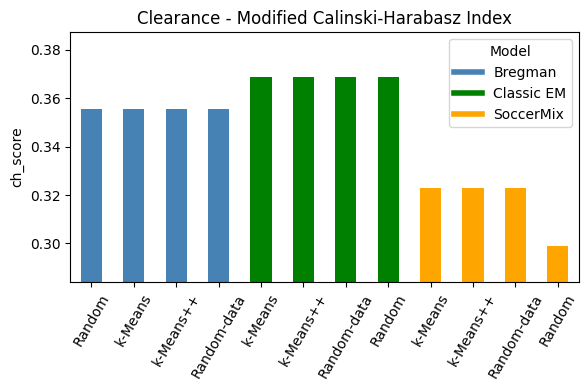

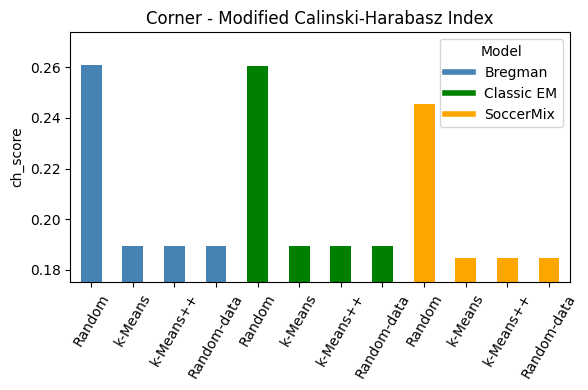

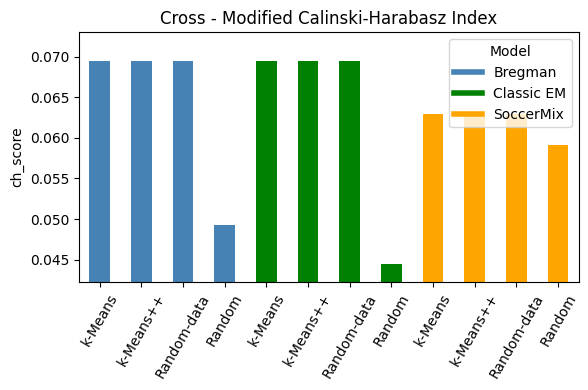

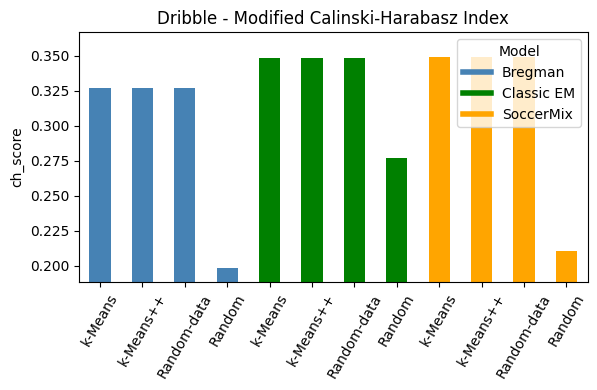

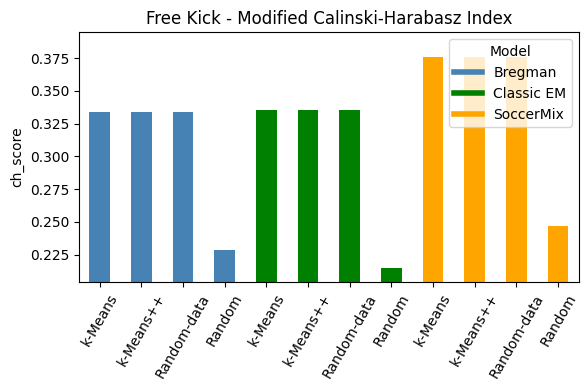

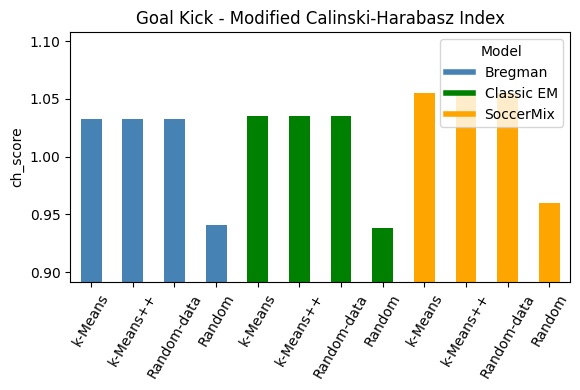

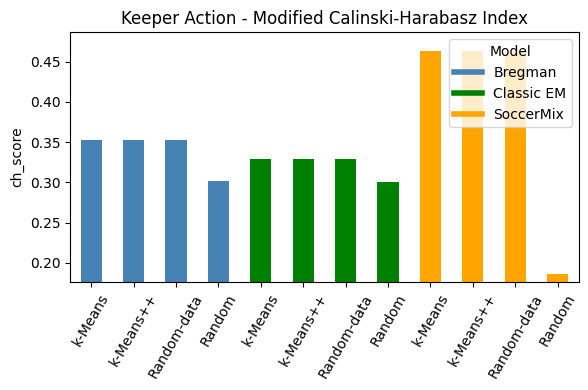

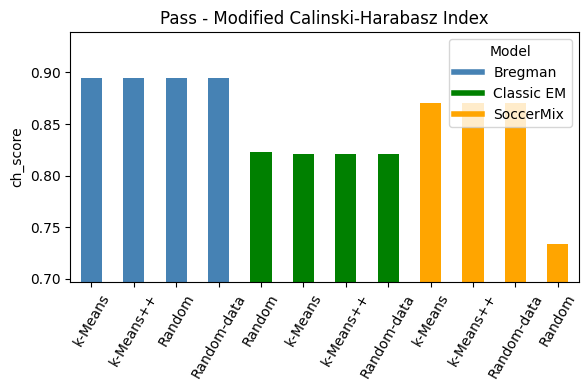

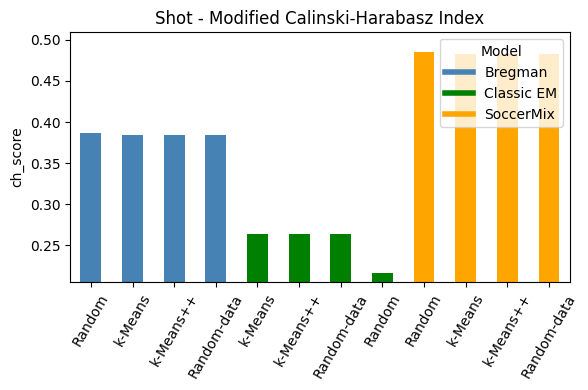

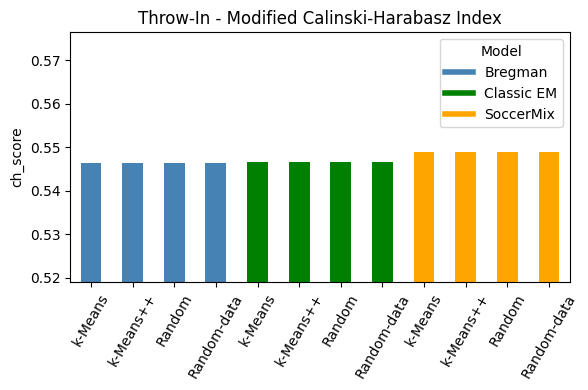

In [23]:
bar_plot_results(dir_summary, "ch_score")

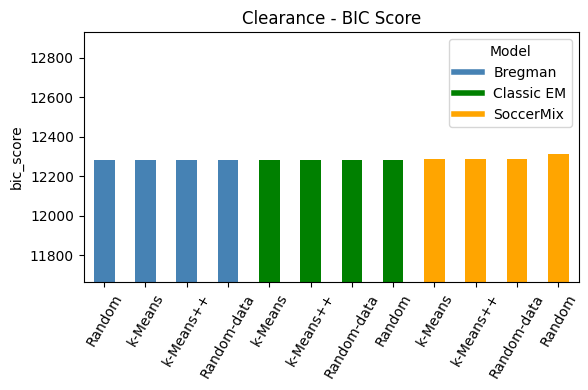

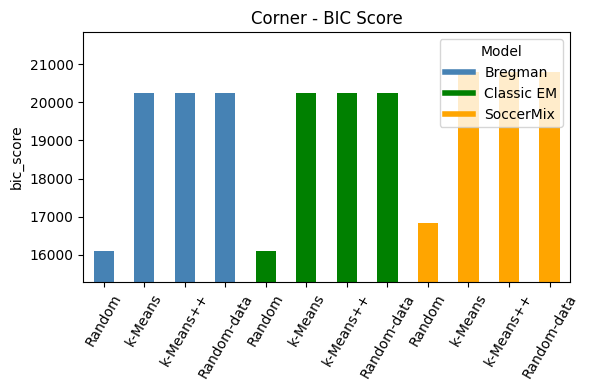

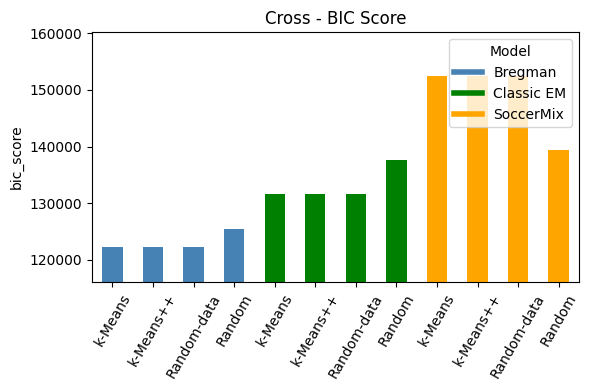

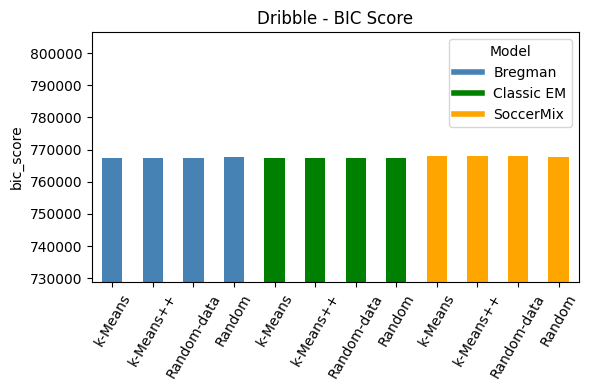

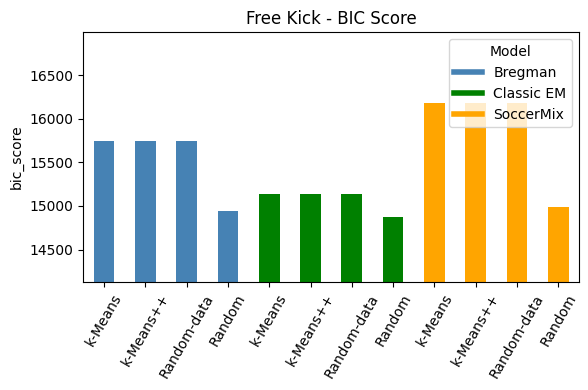

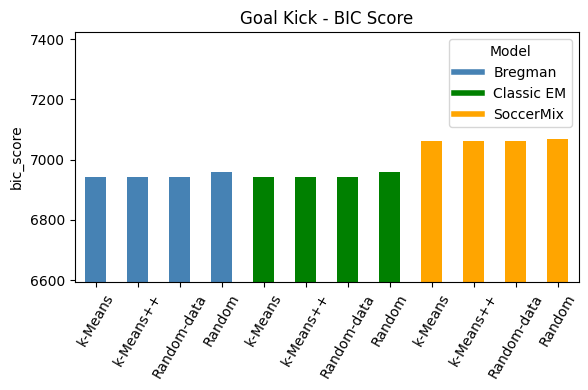

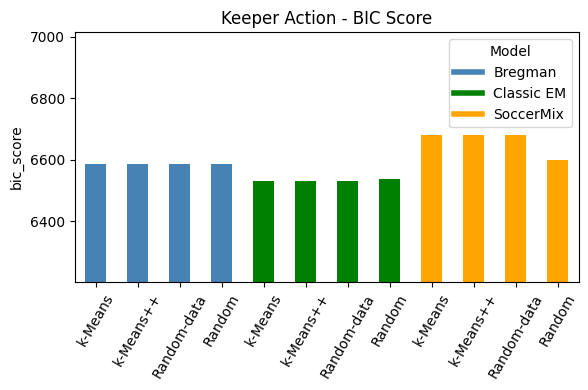

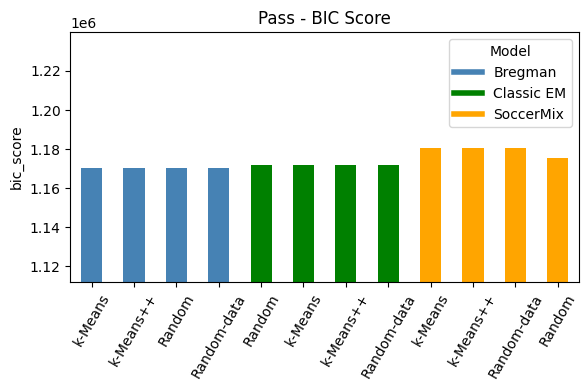

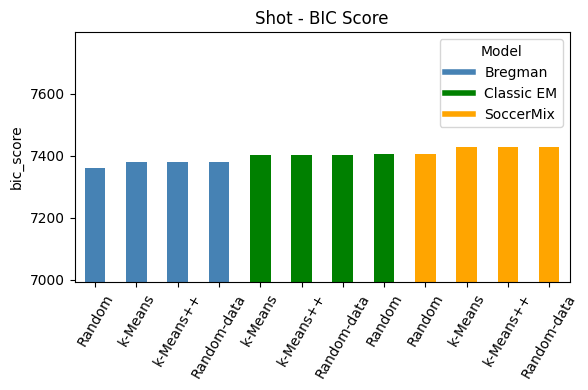

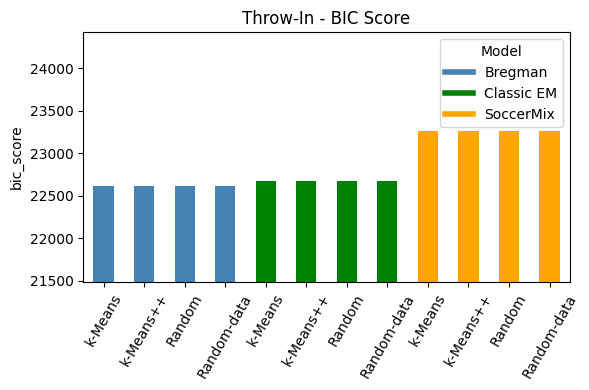

In [24]:
bar_plot_results(dir_summary, "bic_score")

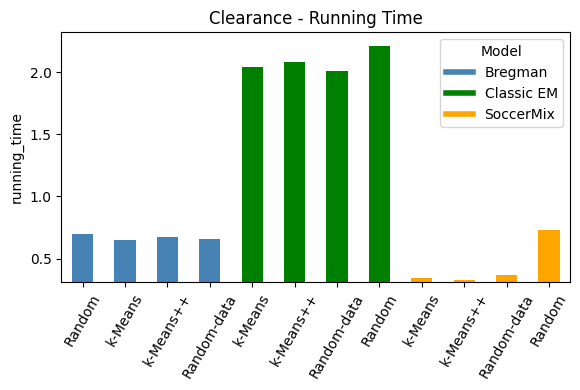

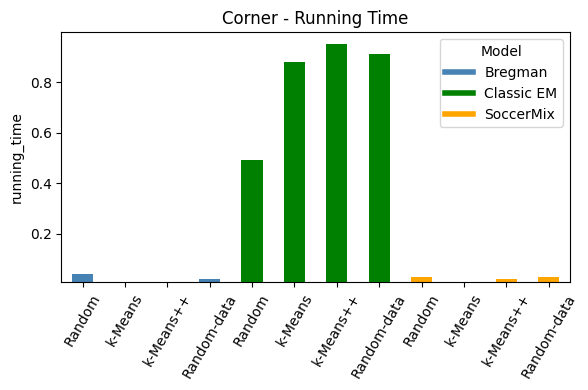

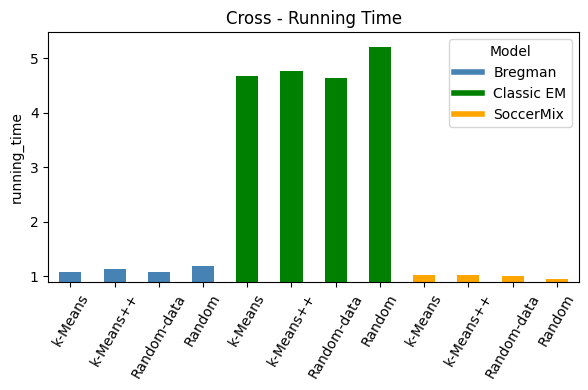

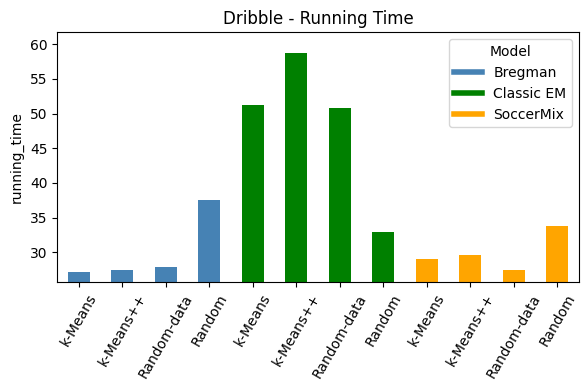

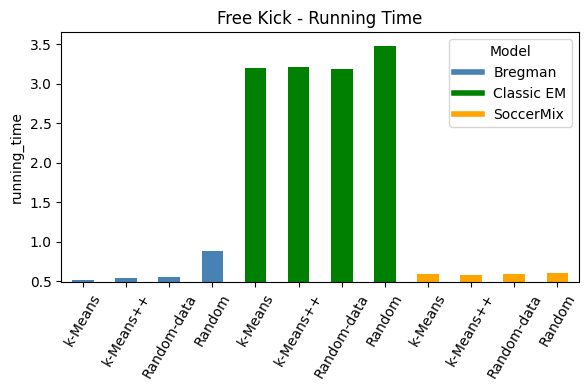

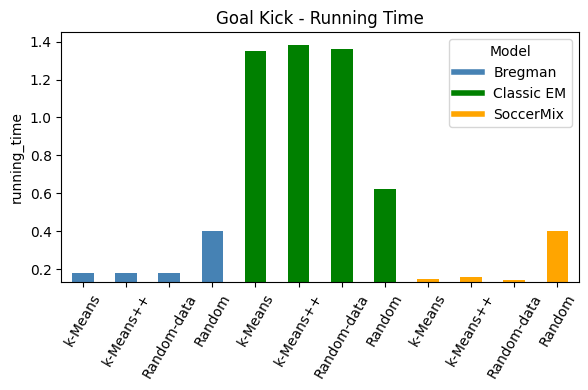

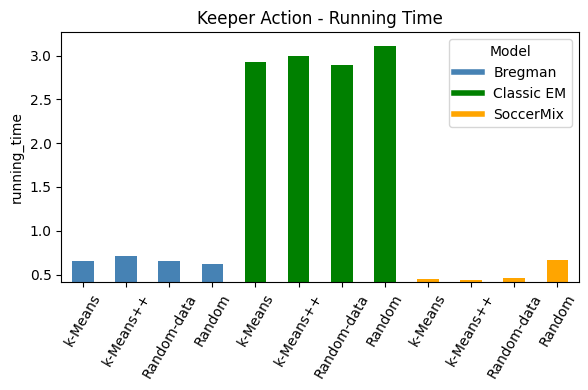

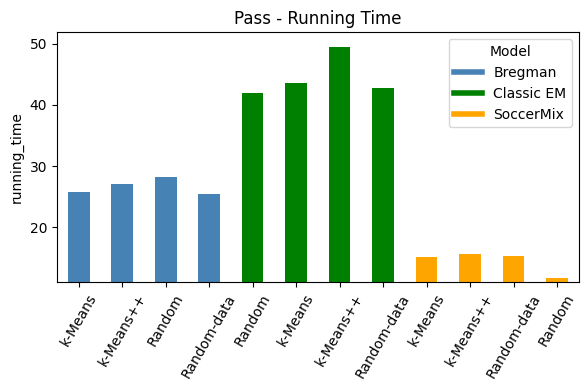

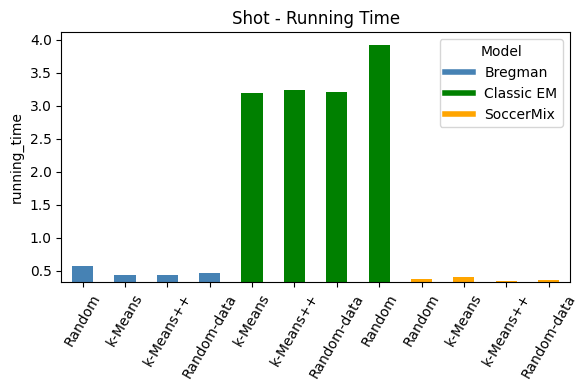

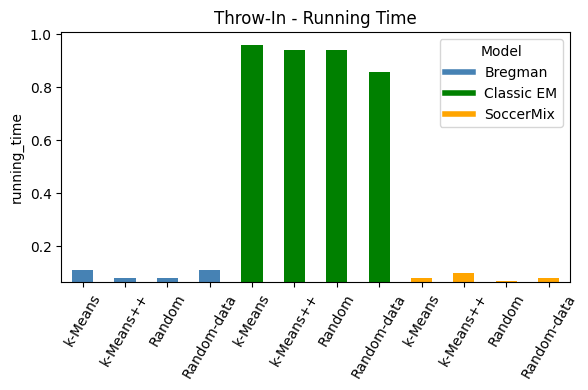

In [25]:
bar_plot_results(dir_summary, "running_time")

In [26]:
df = dir_summary.groupby(["model"]).sum().drop(columns=["action_type", "initialization"])
df.sort_values(by="ch_score", ascending=False, inplace=True)
df


ch_score  count_loc_clusters  count_dir_clusters  bic_score  \
model                                                                        
approximation  18.12096                 120                 340  8755952.0   
bregman        17.61735                 120                 336  8606072.0   
classic        16.91453                 120                 360  8650421.0   

               aic_score  running_time  
model                                   
approximation  8753225.0        190.39  
bregman        8603309.0        241.83  
classic        8647509.0        449.08

In [27]:
def plot_models(action_types, loc_models, experiment):
    init_nice = {
        'random_from_data':'Random-data',
        'random':'Random',
        'k-means':'k-Means',
        'k-means++':'k-Means++'
    }
    action_nice = {
        'clearance': 'Clearance',
        'corner': 'Corner',
        'cross': 'Cross',
        'dribble': 'Dribble',
        'freekick': 'Free Kick',
        'goalkick': 'Goal Kick',
        'keeper_action': 'Keeper Action',
        'pass': 'Pass',
        'shot': 'Shot',
        'throw_in': 'Throw-In'
    }
    model_nice = {'bregman': 'Bregman EM',
                  'approximation': 'SoccerMix',
                  'classic': 'Classic EM'}

    for action_type in action_types:
        for method in ["bregman","approximation","classic"]:
            for init in ["k-means++", "k-means", "random", "random_from_data"]:
                vis.show_all_models(loc_models[action_type],
                                    experiment[method + "," + init][action_type],
                                    title=f"{action_nice[action_type]} - {model_nice[method]} with {init_nice[init]}",
                                    figsize=5)

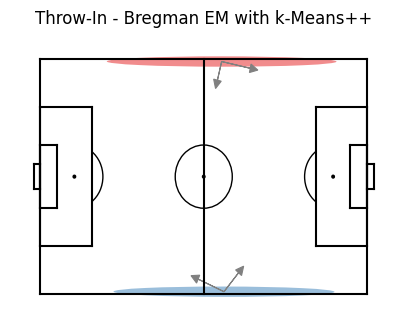

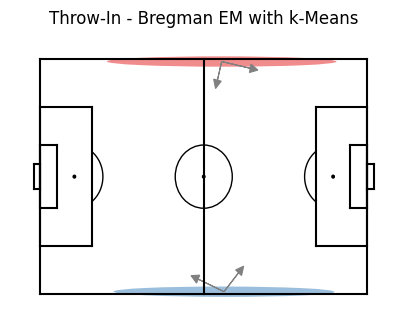

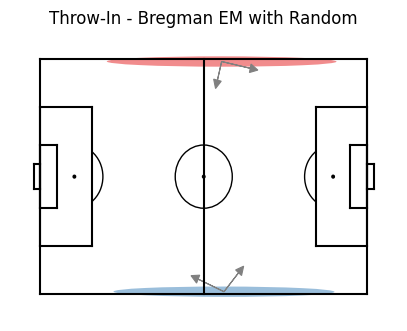

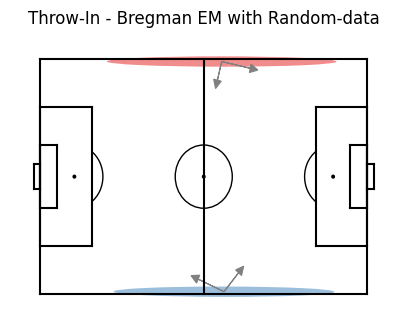

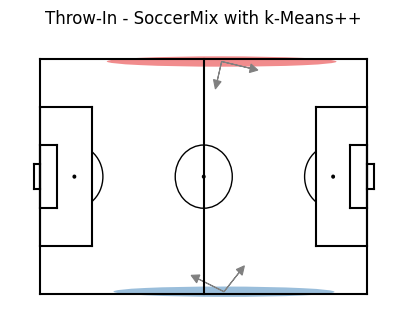

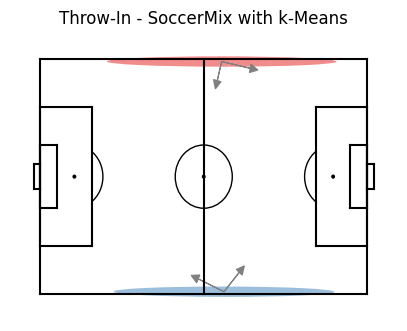

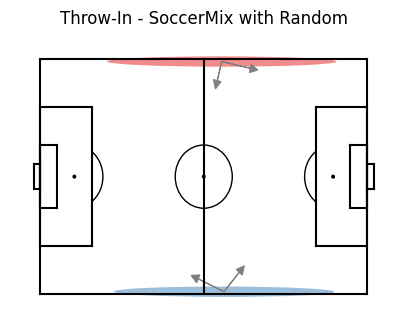

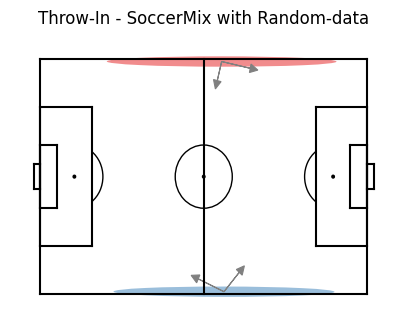

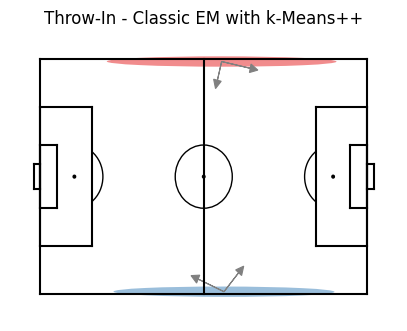

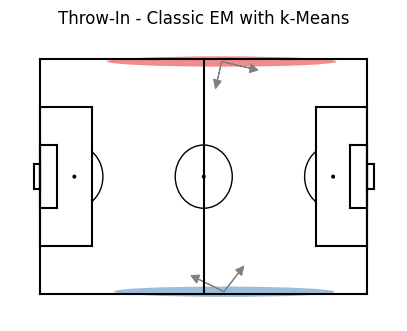

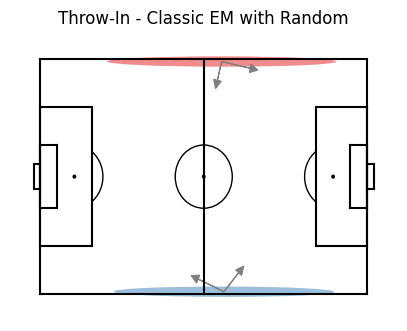

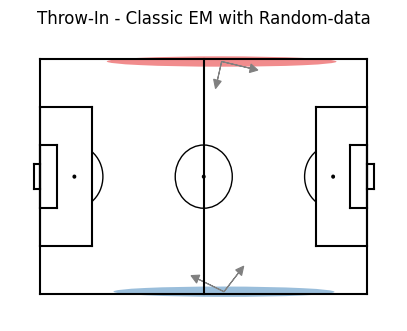

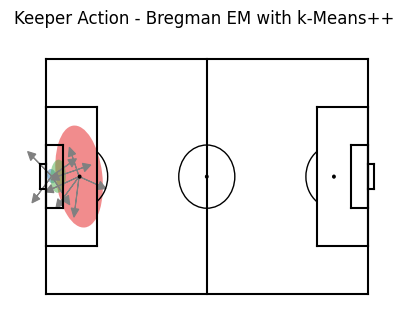

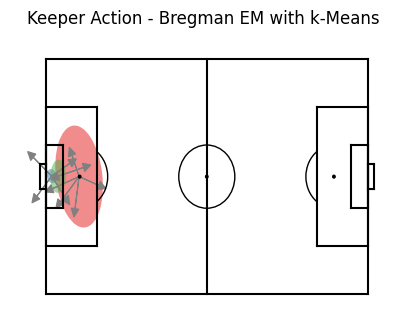

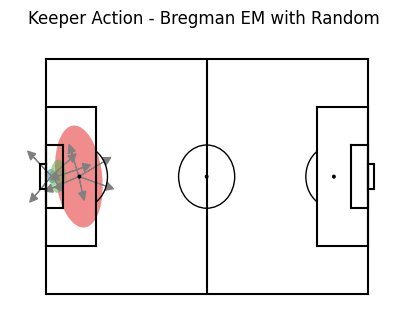

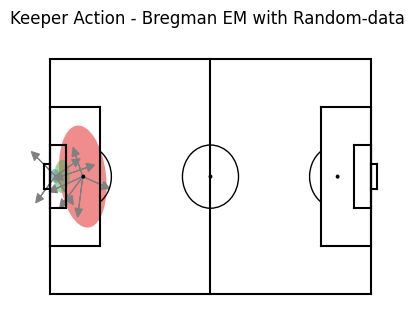

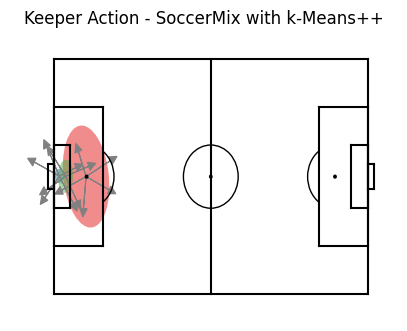

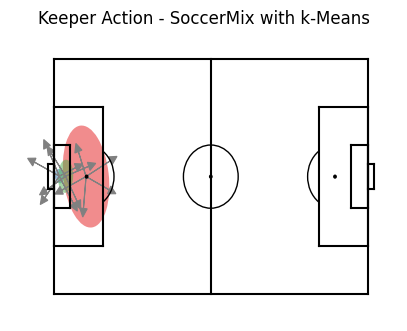

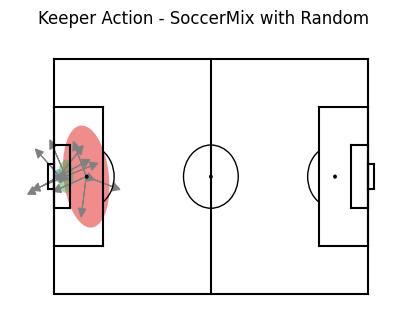

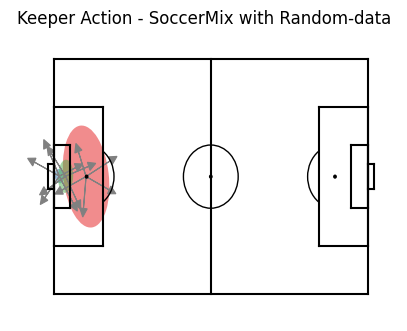

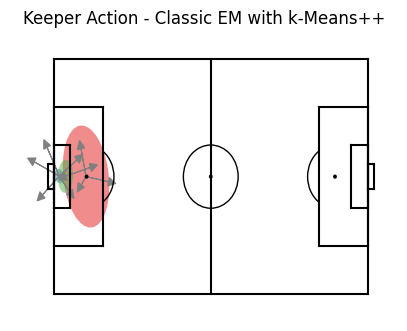

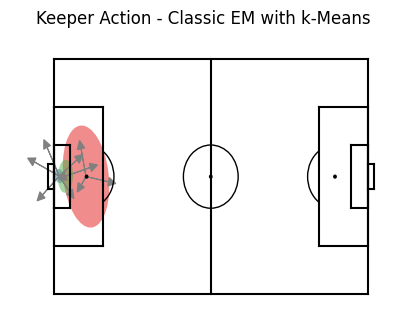

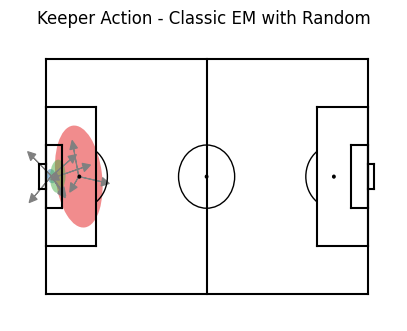

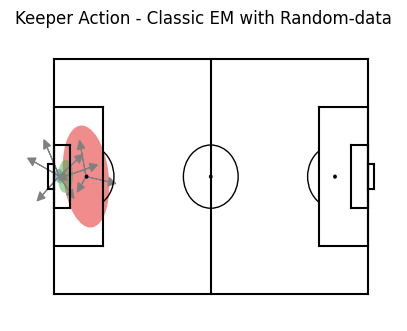

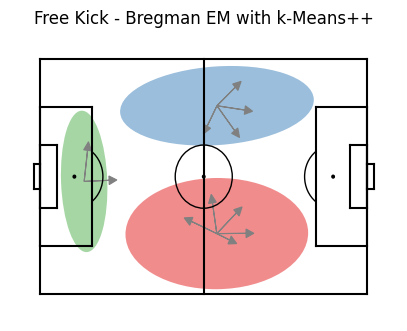

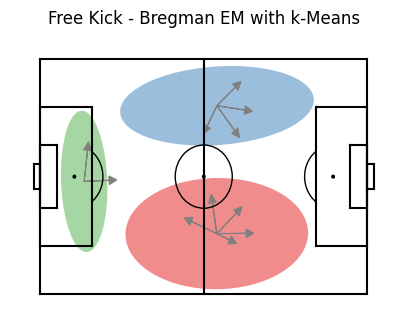

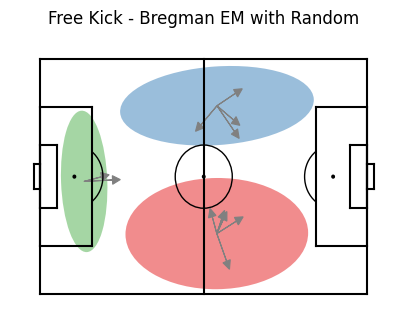

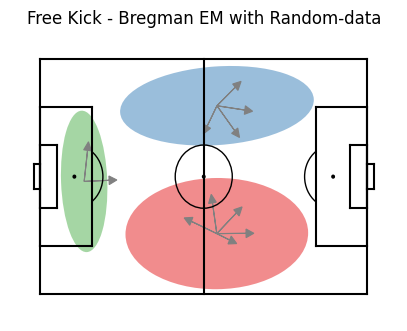

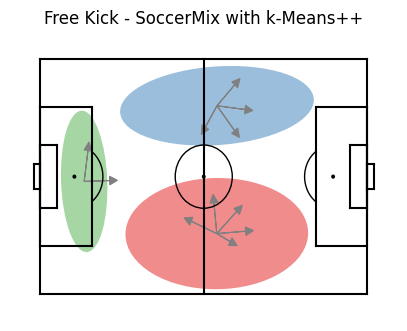

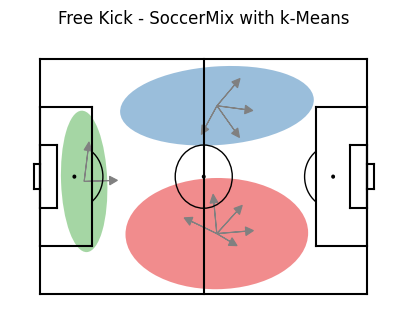

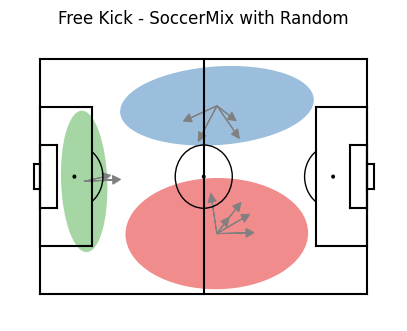

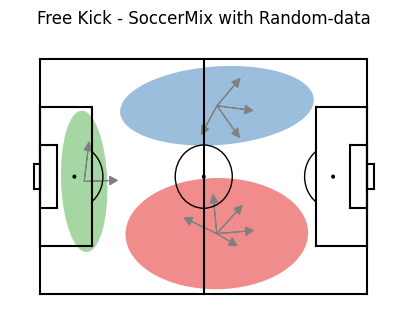

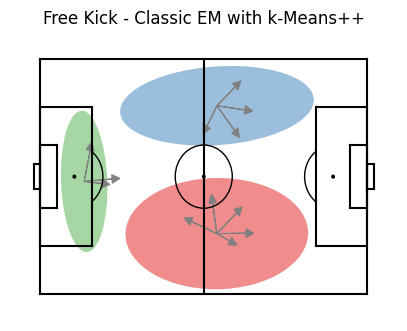

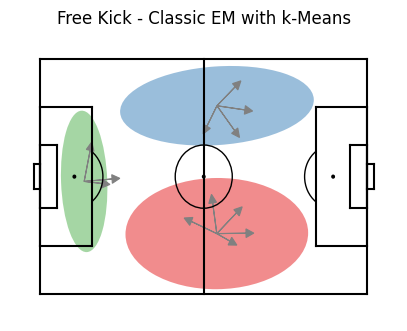

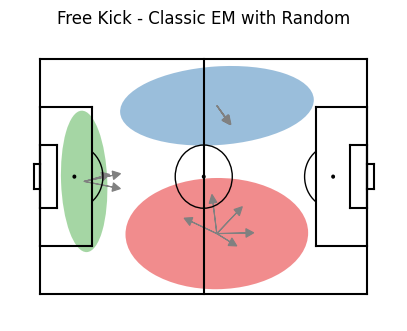

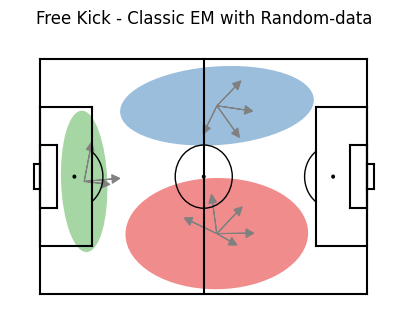

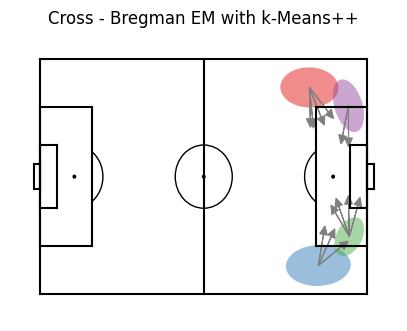

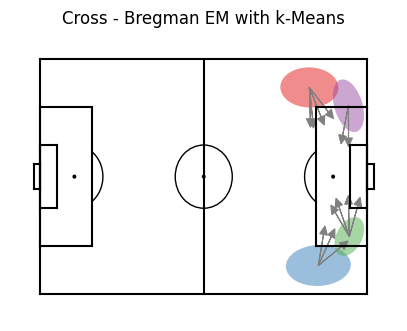

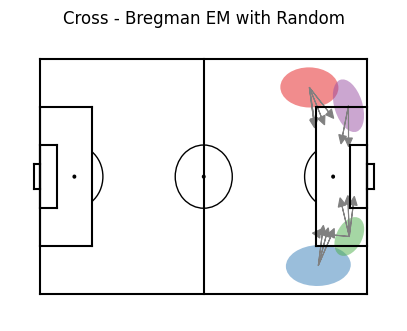

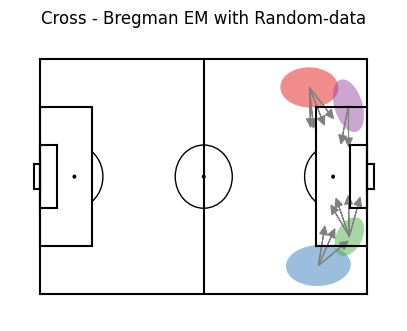

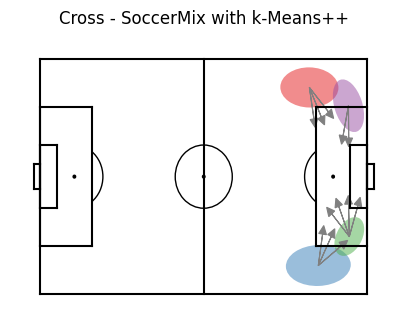

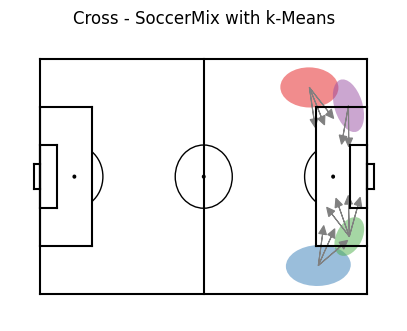

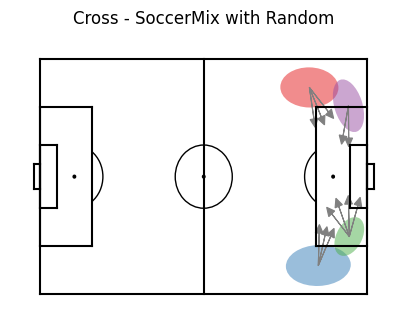

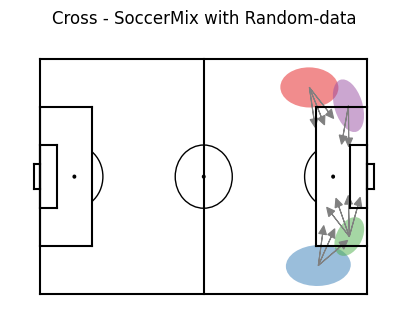

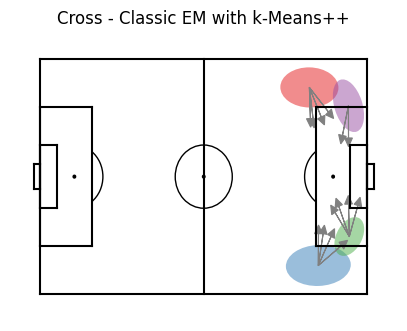

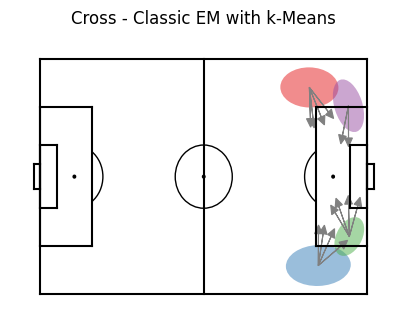

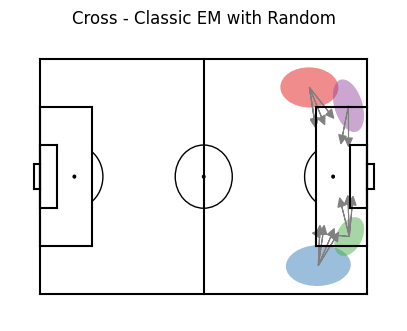

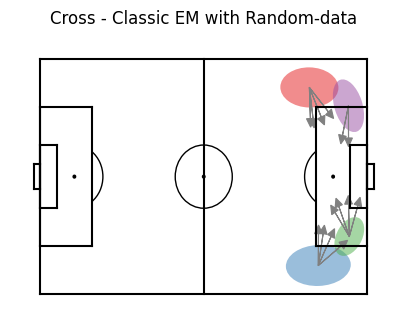

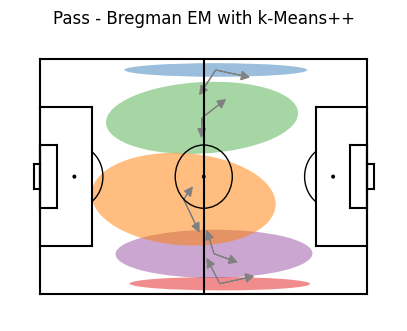

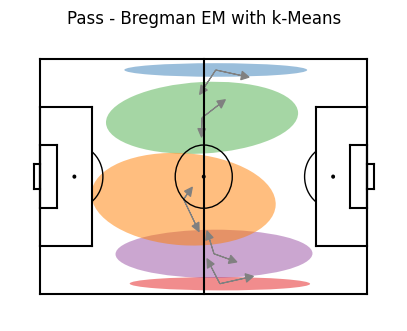

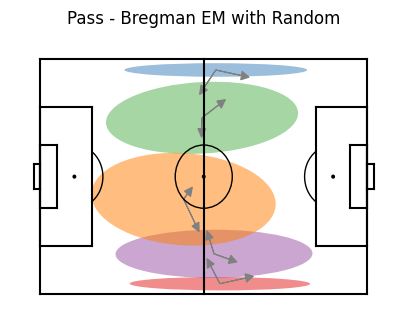

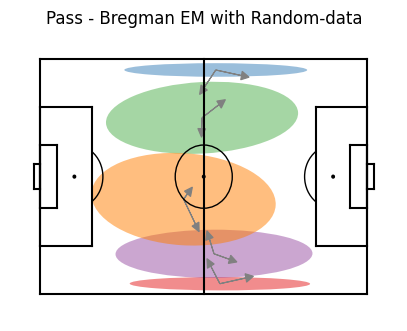

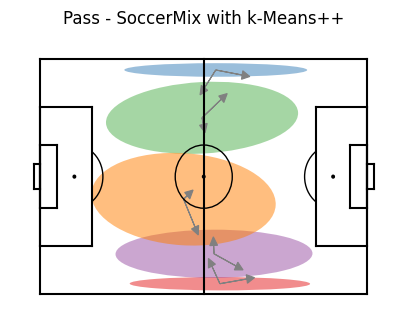

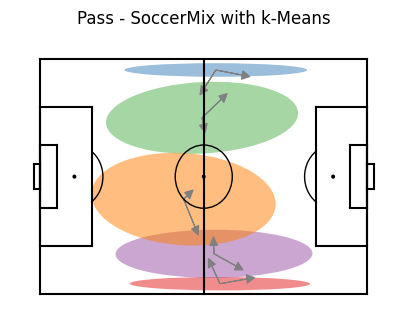

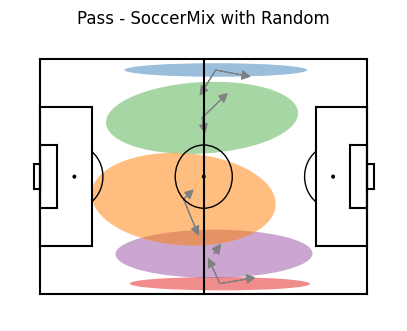

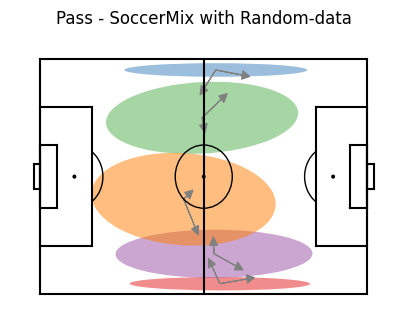

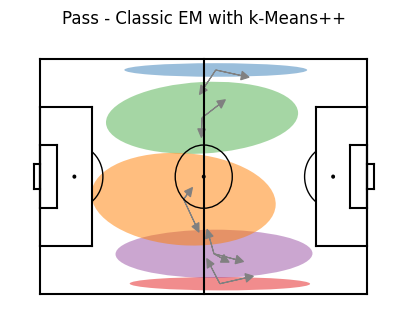

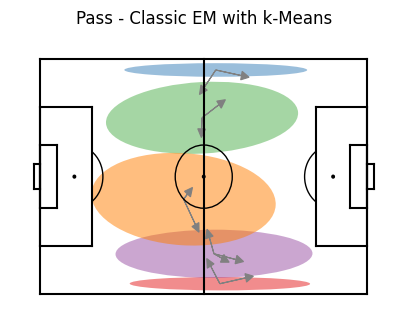

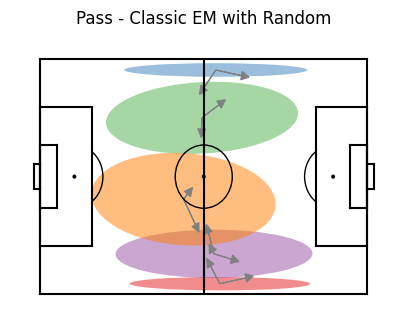

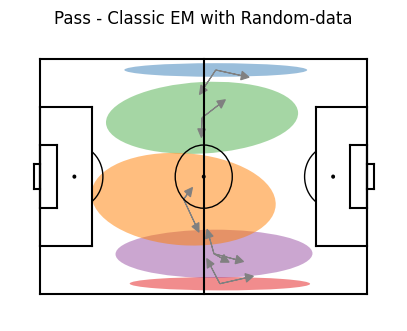

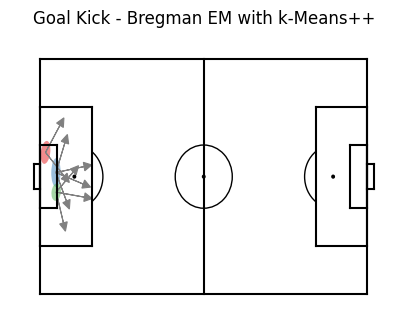

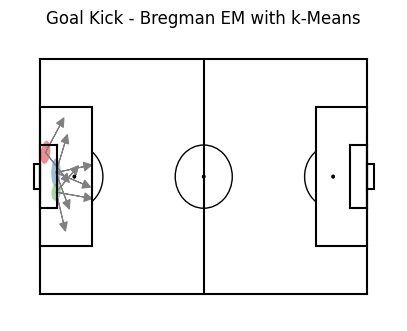

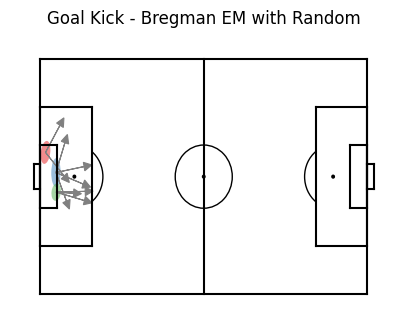

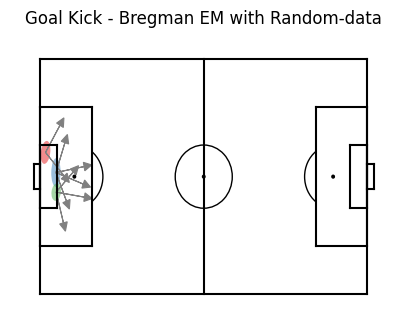

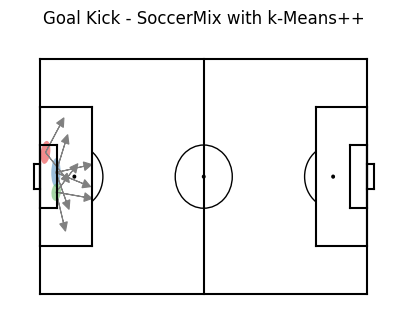

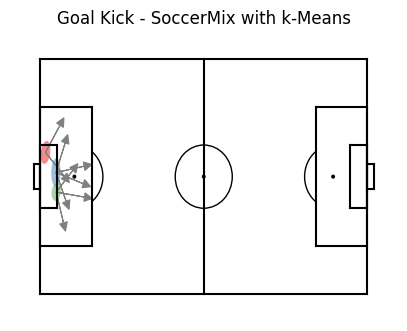

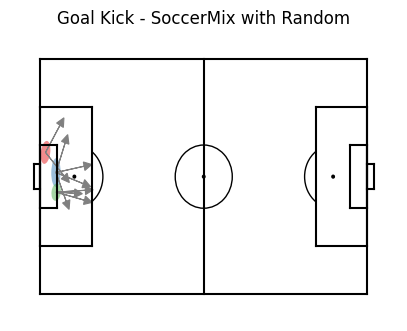

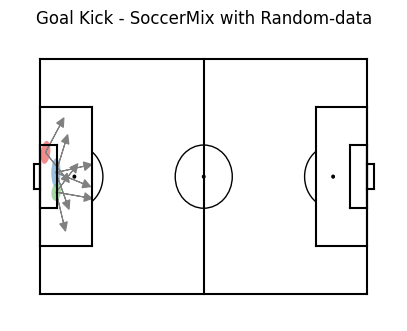

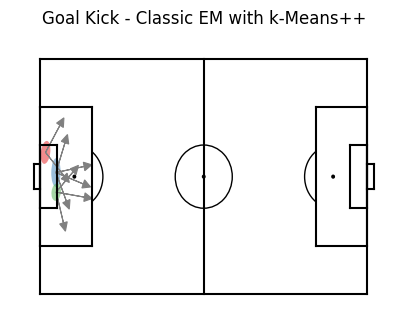

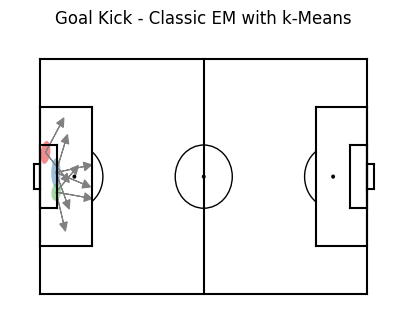

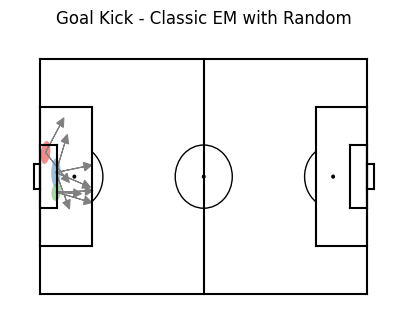

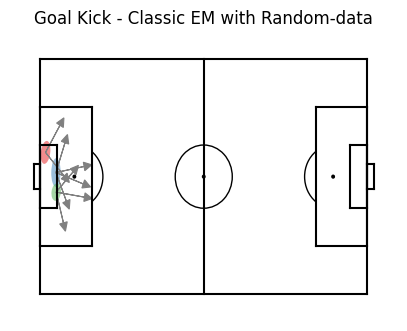

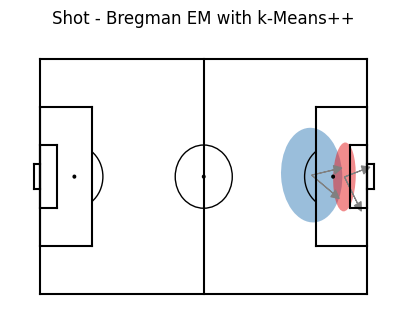

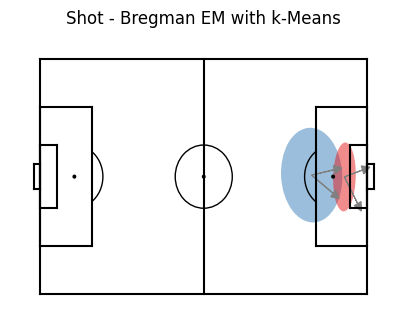

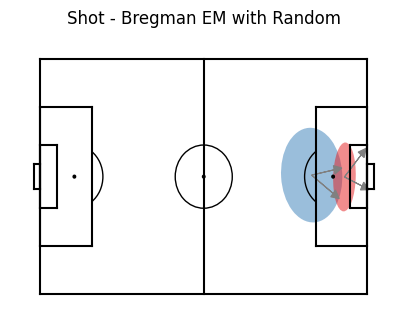

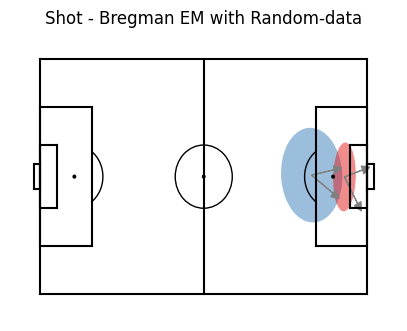

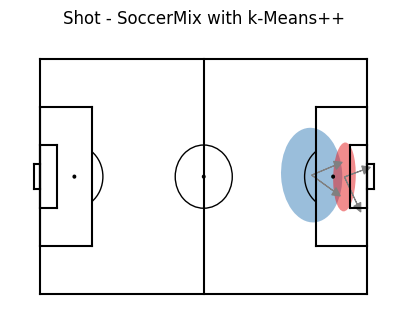

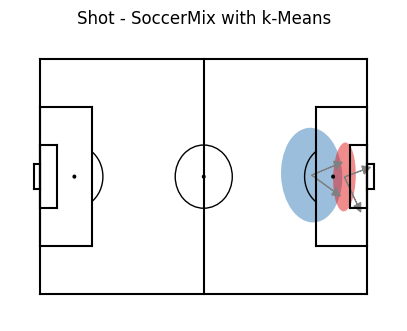

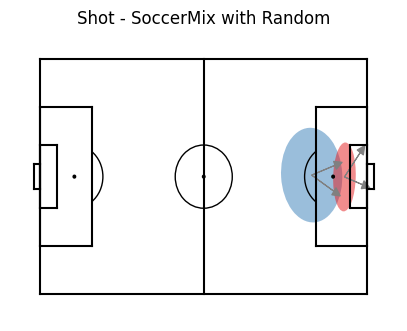

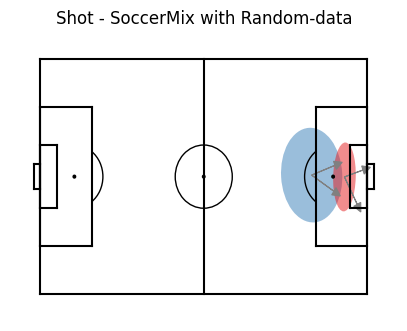

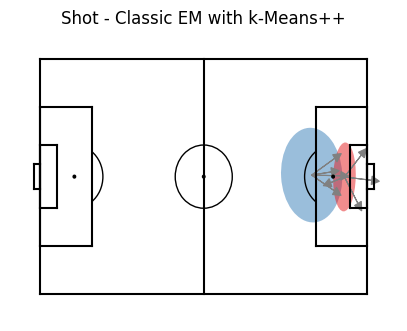

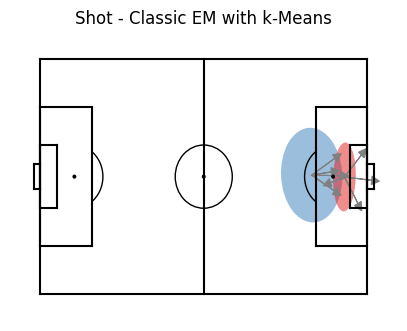

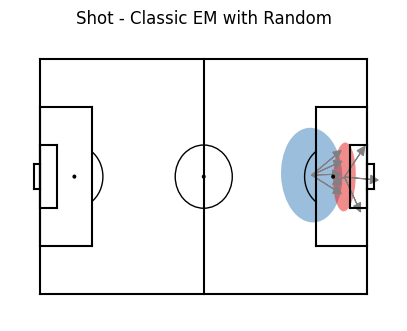

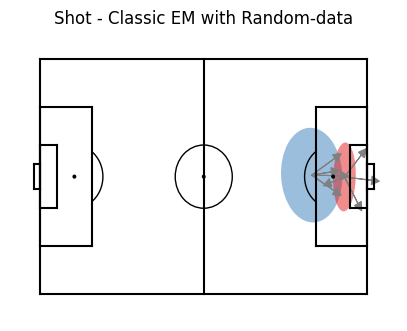

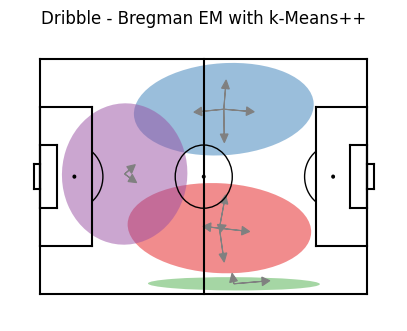

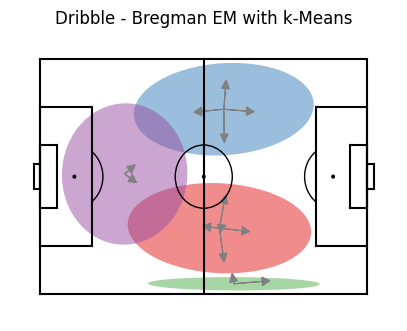

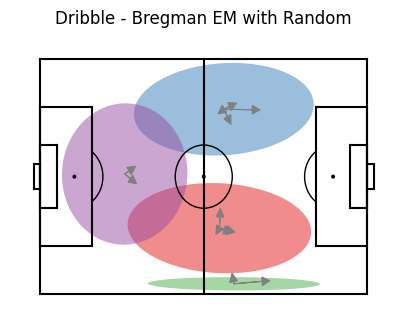

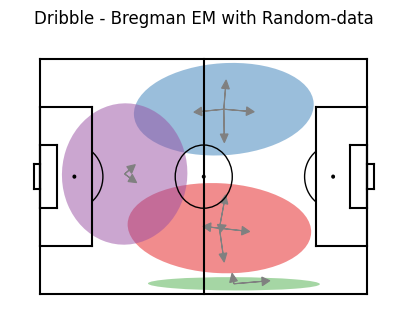

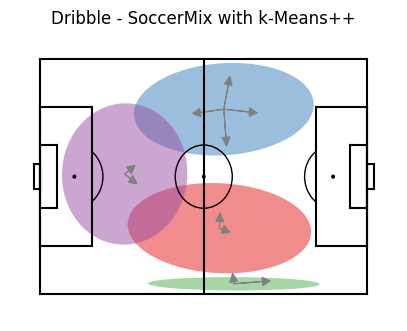

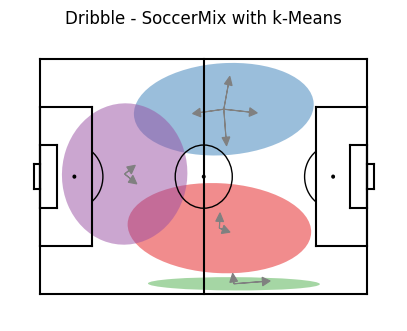

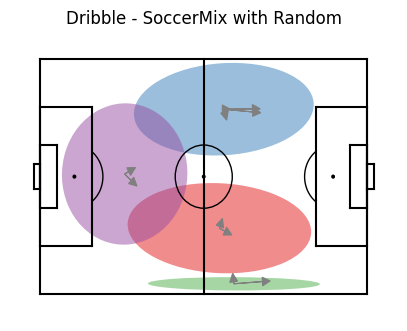

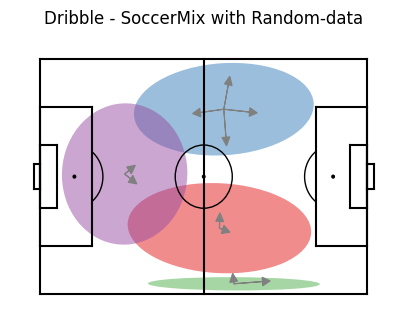

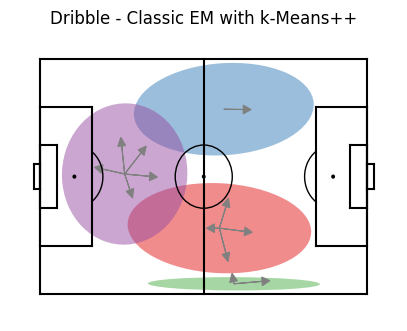

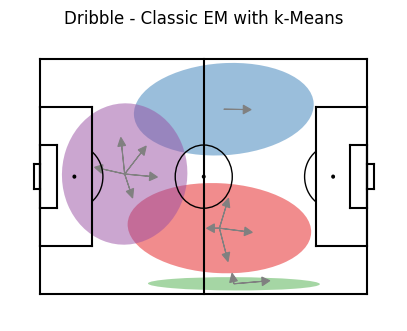

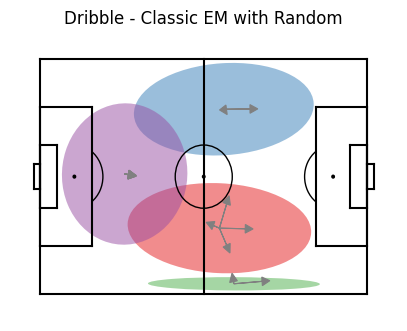

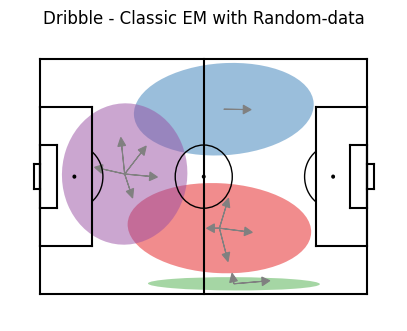

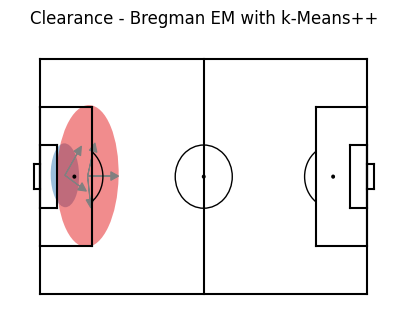

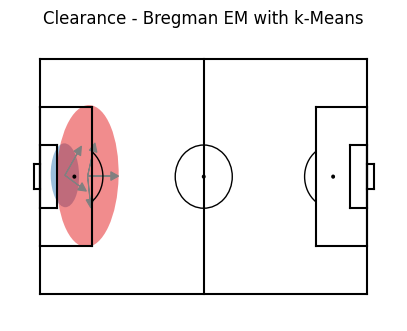

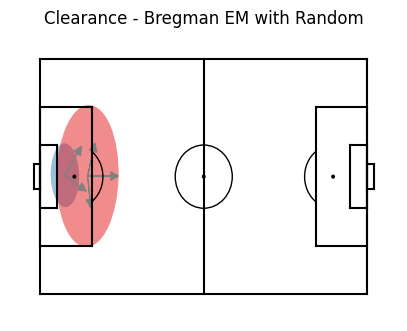

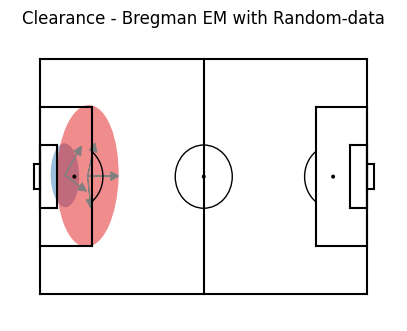

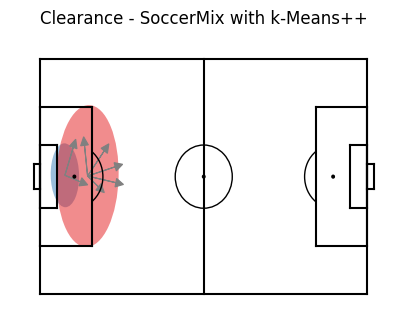

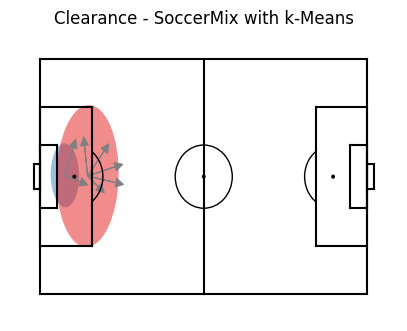

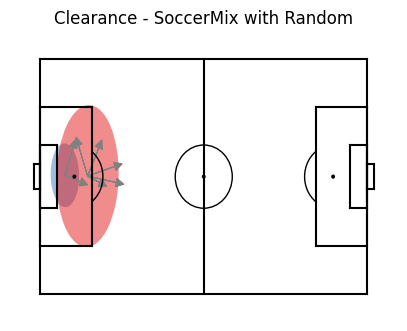

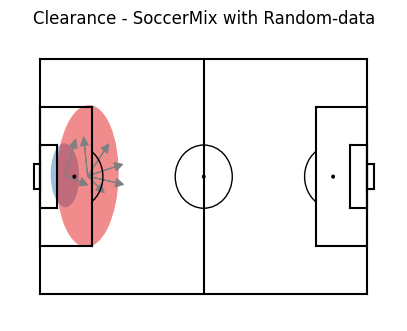

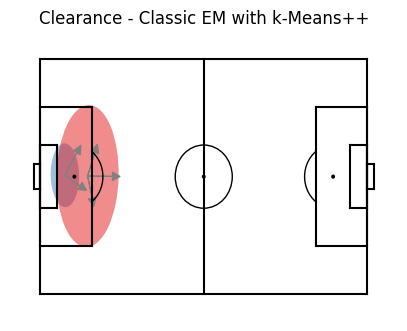

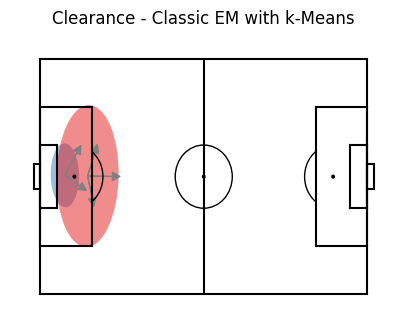

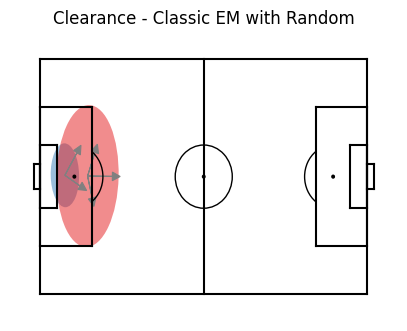

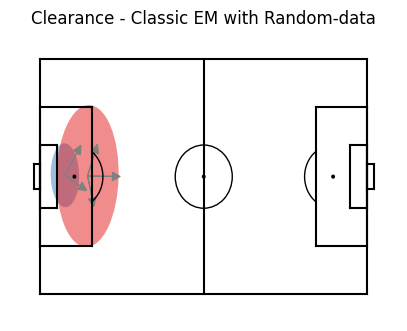

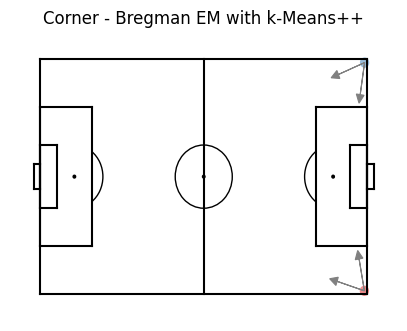

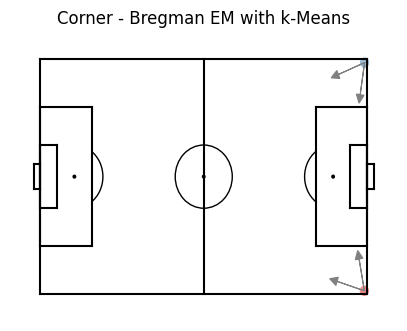

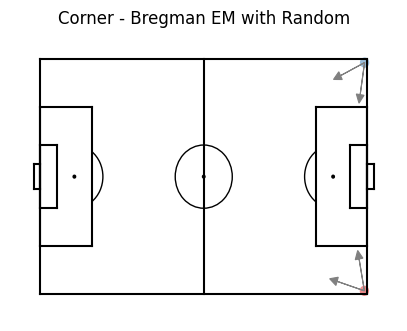

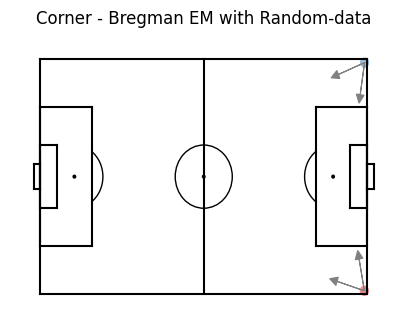

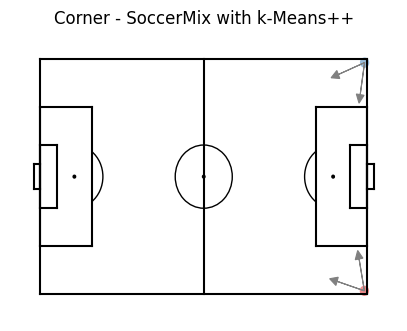

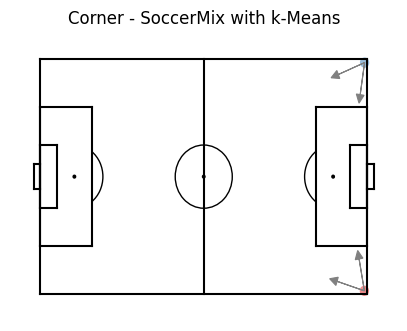

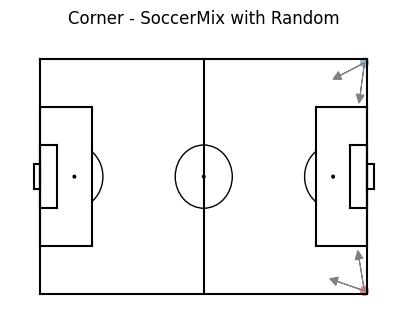

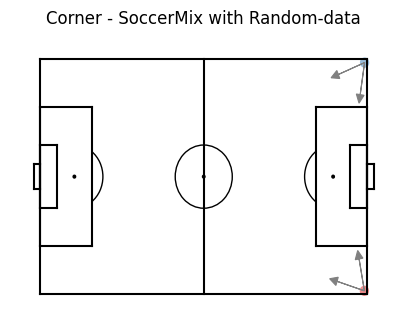

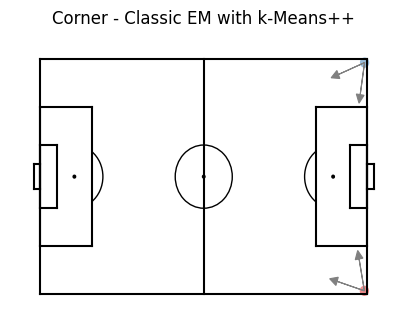

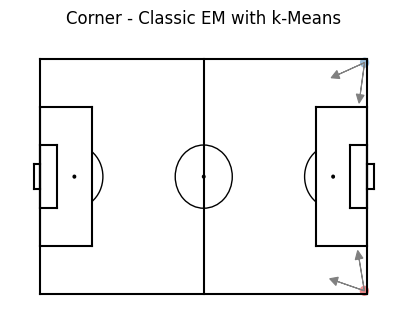

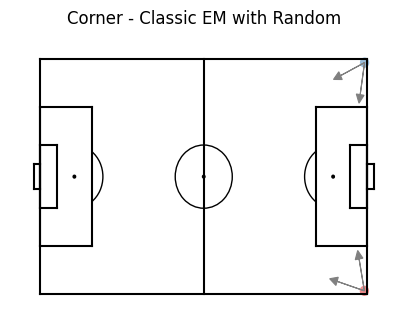

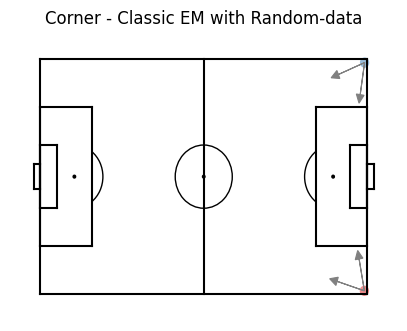

In [28]:
plot_models(action_types, loc_models, experiment)